# 必要なライブラリをimprot

In [1]:
import itertools
from collections import defaultdict

import numpy as np
from scipy import stats

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

# 3D-PCRの変数を定義

In [2]:
sample_size = (12, 8, 10)
shot_num = 10000

# 評価に必要な定数の定義

In [3]:
res = dict(naive=0, arranged=0, equal=0)
log_naive = []
log_arrangement = []
positive_num = []

# Simulator

In [4]:
def calculate_positive_indices(plates):
    """
    platesの配列から再検査が必要なindexを返す

    Parameters
    ----------
    plates : numpy.ndarray
        各plateのpositive/negatieの情報を持つ配列

    Returns
    -------
    retest_indices : list
        再検査が必要なindexのリスト
    """
    # indices = np.nonzero(plates)
    # positives = [(indices[0][i], indices[1][i], indices[2][i]) for i in range(len(indices[0]))]

    C_0 = np.where(np.any(plates, axis = (1, 2)))[0].tolist()
    C_1 = np.where(np.any(plates, axis = (0, 2)))[0].tolist()
    C_2 = np.where(np.any(plates, axis = (0, 1)))[0].tolist()
    re_test = list(itertools.product(C_0, C_1, C_2))
    retest_indices = [j + i*sample_size[1] + sample_size[0]*sample_size[1]*k for i, j, k in re_test]

    # return (c_x, c_y, c_z), retest_indices
    return len(retest_indices)

In [188]:
def visualizer_positive(plates, positive, title='Retest required well(Red wells need to be retested)'):
    fig = plt.figure(figsize=(20, 20),dpi=200)
    cnt = 0
    
    for well_number in range(sample_size[2]):
        ax = fig.add_subplot(2, 5, well_number+1)
        well_size = 0.8
        
        for i in range(sample_size[0]):
            for j in range(sample_size[1]):
                if cnt in positive:
                    color = 'red'
                else:
                    color = 'white'
                # rect = patches.Rectangle((i+0.1, 7-j+0.1), well_size, well_size, linewidth=1, edgecolor='black', facecolor=color)
                circle = patches.Circle((i+0.5, 7-j+0.5), well_size/2, edgecolor='black', facecolor=color)
                # ax.add_patch(rect)
                ax.add_patch(circle)
    
                cnt += 1
        
        ax.set_xticks([i + 0.5 for i in range(12)])
        ax.set_xticklabels([i for i in range(1, 13)])
        
        ax.set_yticks([i + 0.5 for i in range(8)])
        ax.set_yticklabels([i for i in range(1, 9)][::-1])  # Y軸のラベルは逆順
        
        ax.set_xlim(-0.1, 12.1)
        ax.set_ylim(-0.1, 8.1)
        
        ax.set_aspect('equal', 'box')
        
        ax.set_title(f'{sample_size[0] * sample_size[1]}well plate {well_number+1}')
    
    fig.suptitle(title, fontsize=30, y=0.65)
    fig.subplots_adjust(wspace=0.3, hspace=-0.83)

    return 0
    
def visualizer(plates, title='Retest required well(Red wells need to be retested)'):
    re_test = list(itertools.product(np.where(np.any(plates, axis = (1, 2)))[0].tolist(), np.where(np.any(plates, axis = (0, 2)))[0].tolist(), np.where(np.any(plates, axis = (0, 1)))[0].tolist()))
    re_test_index = [j + i*sample_size[1] + sample_size[0]*sample_size[1]*k for i, j, k in re_test]

    fig = plt.figure(figsize=(20, 20),dpi=200)
    cnt = 0
    
    for well_number in range(sample_size[2]):
        ax = fig.add_subplot(2, 5, well_number+1)
        well_size = 0.8
        
        for i in range(sample_size[0]):
            for j in range(sample_size[1]):
                if cnt in re_test_index:
                    color = 'red'
                else:
                    color = 'white'
                # rect = patches.Rectangle((i+0.1, 7-j+0.1), well_size, well_size, linewidth=1, edgecolor='black', facecolor=color)
                circle = patches.Circle((i+0.5, 7-j+0.5), well_size/2, edgecolor='black', facecolor=color)
                # ax.add_patch(rect)
                ax.add_patch(circle)
    
                cnt += 1
        
        ax.set_xticks([i + 0.5 for i in range(12)])
        ax.set_xticklabels([i for i in range(1, 13)])
        
        ax.set_yticks([i + 0.5 for i in range(8)])
        ax.set_yticklabels([i for i in range(1, 9)][::-1])  # Y軸のラベルは逆順
        
        ax.set_xlim(-0.1, 12.1)
        ax.set_ylim(-0.1, 8.1)
        
        ax.set_aspect('equal', 'box')
        
        ax.set_title(f'{sample_size[0] * sample_size[1]}well plate {well_number+1}')
    
    fig.suptitle(title, fontsize=30, y=0.65)
    fig.subplots_adjust(wspace=0.3, hspace=-0.83)

    return 0

In [86]:
def check_significant_difference(sample_1, sample_2):
    t_stat, p_value = stats.ttest_rel(sample_1, sample_2)

    if p_value < 0.05 and t_stat > 0:
        return True
    else:
        return False

In [ ]:
plates = np.zeros(sample_size)
plates[[1, 2, 0]] = 1
plates[[1, 5, 6]] = 1
# visualizer_positive(plates, (10, 589))
visualizer(plates)

0

## Case-1

In [90]:
result_1_low = []
result_1_med = []
result_1_high = []
cases = [1, 5, 12]

for data_density in range(len(cases)):
    # fix seed
    np.random.seed(0)
    for _ in range(shot_num):
        positive_index = np.random.randint(0, 960, cases[data_density])
        positive_index = np.unravel_index(positive_index, (12, 8, 10))
        
        plates = np.zeros(sample_size)
        plates[positive_index] = 1
        
        if data_density == 0:
            result_1_low.append(calculate_positive_indices(plates))
        elif data_density == 1:
            result_1_med.append(calculate_positive_indices(plates))
        elif data_density == 2:
            result_1_high.append(calculate_positive_indices(plates))

<BarContainer object of 1 artists>

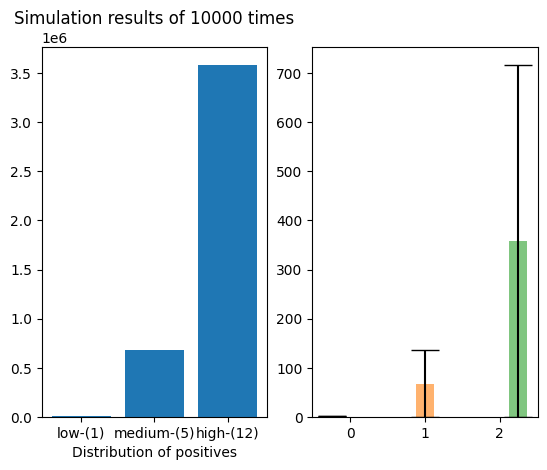

In [93]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 2, 1)
ax_1.bar([0, 1, 2], [sum(result_1_low), sum(result_1_med), sum(result_1_high)], label=['hoge', 'hoge', 'hoge'])
ax_1.set_xlabel('Distribution of positives')
ticks_location = [0, 1, 2]  # この位置に目盛りを設定
labels = [f'low-({cases[0]})', f'medium-({cases[1]})', f'high-({cases[2]})']   # このラベルを表示
ax_1.set_xticks(ticks_location)
ax_1.set_xticklabels(labels)
ax_1.set_title(f'Simulation results of {shot_num} times')


ax_2 = fig.add_subplot(1, 2, 2)
mean_low = np.mean(result_1_low)
std_dev_low = np.std(result_1_low)
mean_med = np.mean(result_1_med)
std_dev_med = np.mean(result_1_med)
mean_high = np.mean(result_1_high)
std_dev_high = np.mean(result_1_high)

bar_width = 0.25
positions = np.arange(3)
ax_2.bar(positions[0] - bar_width, mean_low, bar_width, yerr=std_dev_low, align='center', alpha=0.6, ecolor='black', capsize=10, label='low')
ax_2.bar(positions[1], mean_med, bar_width, yerr=std_dev_med, align='center', alpha=0.6, ecolor='black', capsize=10, label='med')
ax_2.bar(positions[2] + bar_width, mean_high, bar_width, yerr=std_dev_high, align='center', alpha=0.6, ecolor='black', capsize=10, label='high')

In [58]:
max(result_1_high)-min(result_1_high)

620

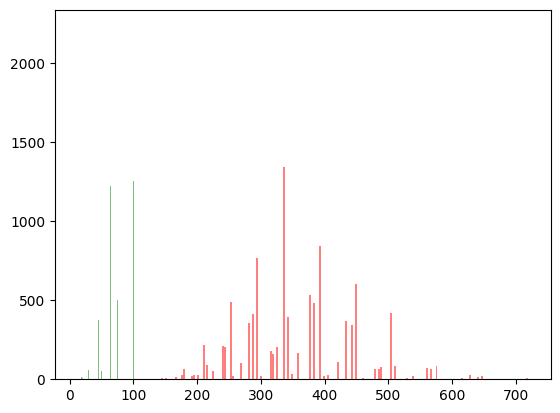

In [61]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.hist(result_1_low, bins=1, alpha=0.5, color='blue')
ax.hist(result_1_med, bins=100, alpha=0.5, color='green')
ax.hist(result_1_high, bins=200, alpha=0.5, color='red')
fig.show()

## case-2

b
10000 10000
a
677680 50000
a
3583140 120000


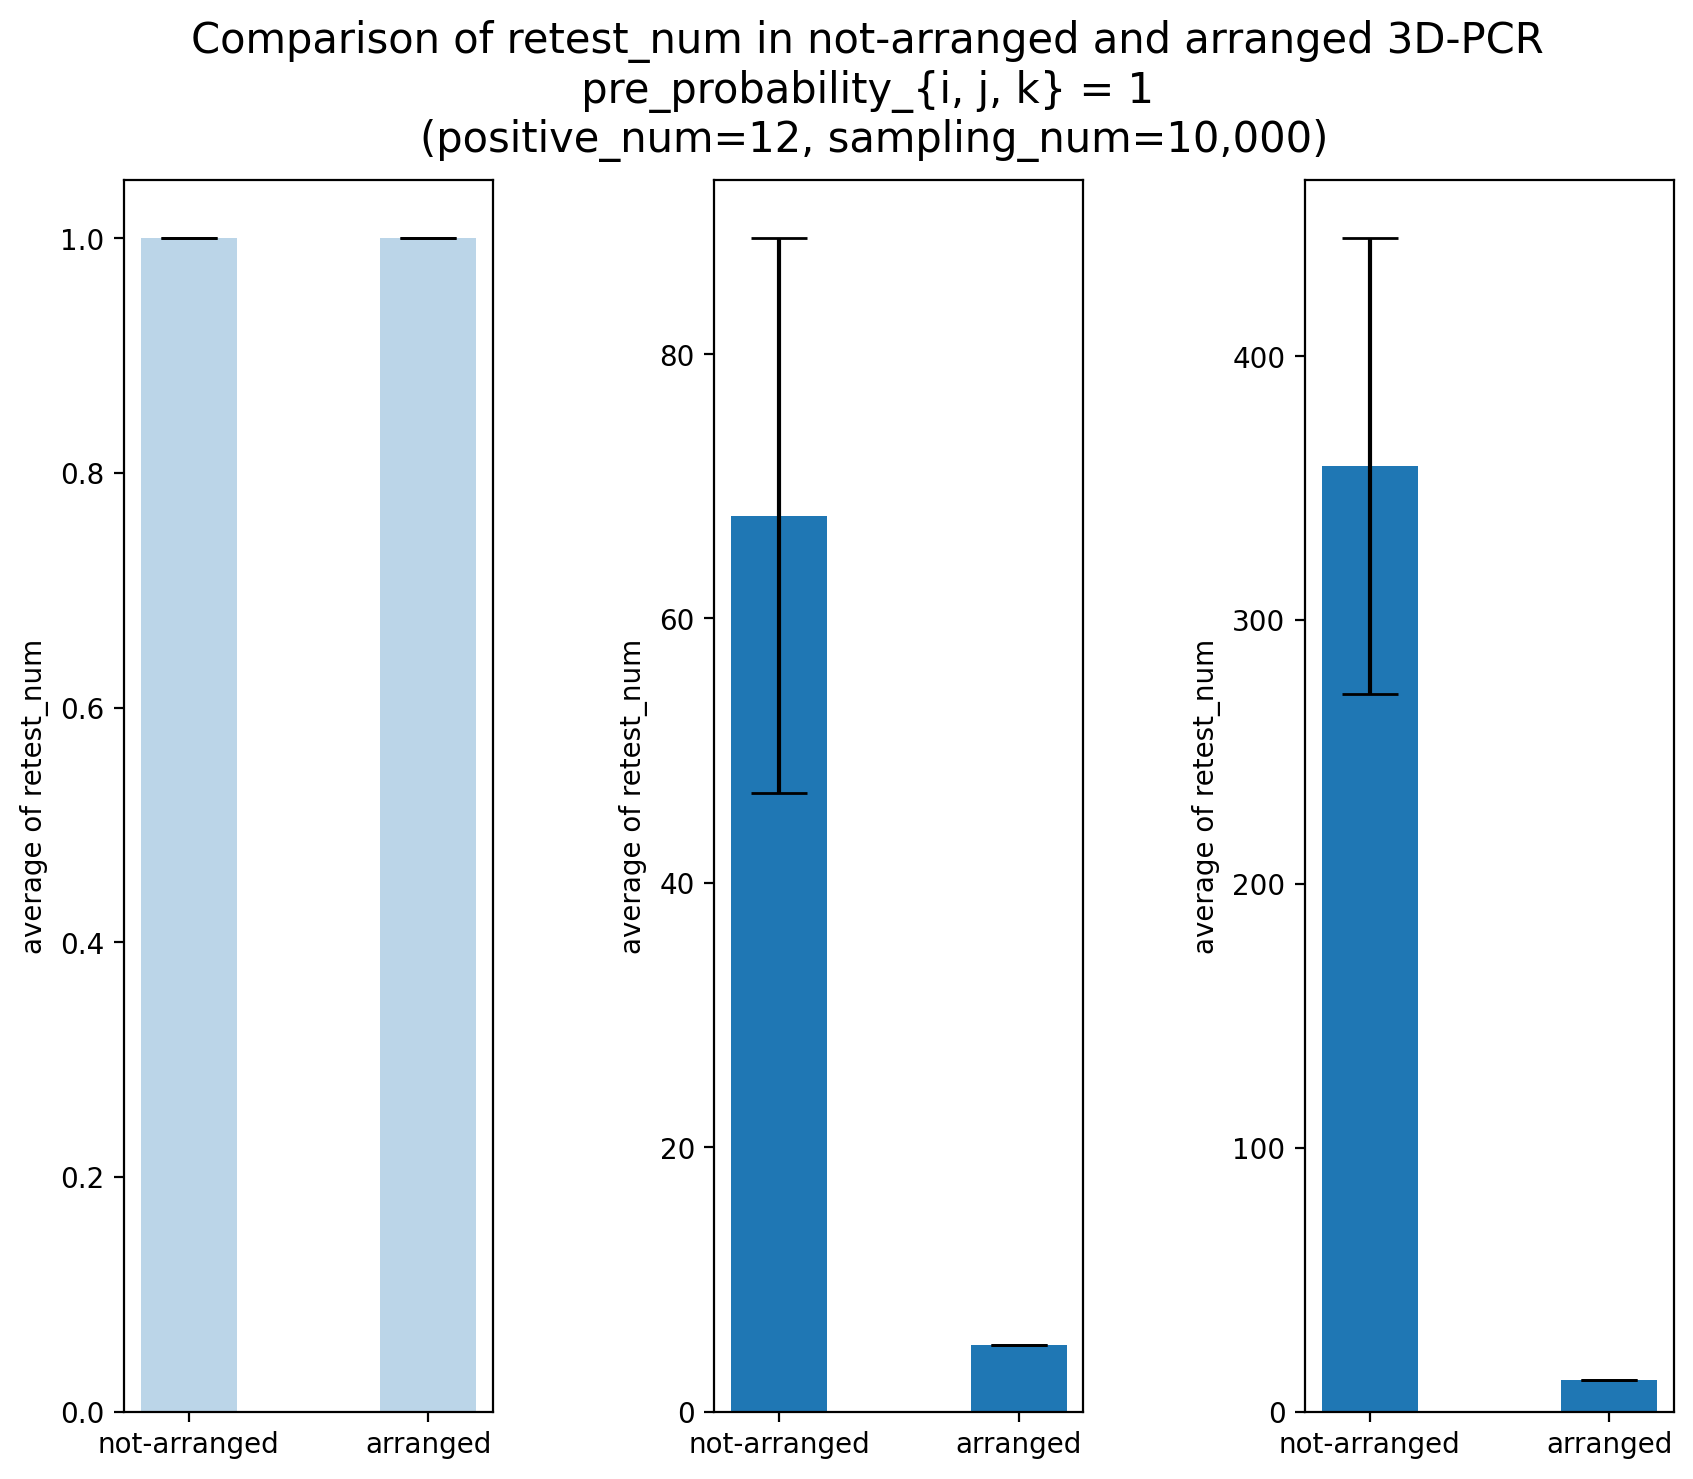

In [183]:
result_2_pure = [] # densityごとに区切っている
result_2_arranged = []
cases = [1, 5, 12]

for data_density in range(len(cases)):
    temp_pure = []
    temp_arranged = []
    # fix seed
    np.random.seed(0)
    for _ in range(shot_num):
        positive_index = np.random.choice(960, cases[data_density], replace=False)

        positive_index = np.unravel_index(positive_index, (12, 8, 10))

        plates = np.zeros(sample_size)
        plates[positive_index] = 1

        arranged_plates = np.zeros(sample_size)
        arranged_plates[:cases[data_density], 0, 0] = 1
        
        print(len(np.nonzero(arranged_plates)[0])) if len(np.nonzero(arranged_plates)[0]) != cases[data_density] else None
        # check upper bound and lower bound
        print('a', len(np.nonzero(arranged_plates)[0])) if not(cases[data_density] <= calculate_positive_indices(arranged_plates) <= min(cases[data_density], 12) * min(cases[data_density], 8), min(cases[data_density], 10)) else None

        temp_pure.append(calculate_positive_indices(plates))
        temp_arranged.append(calculate_positive_indices(arranged_plates))

    result_2_pure.append(temp_pure)
    result_2_arranged.append(temp_arranged)

# visualize
fig = plt.figure(figsize=(10, 8), dpi=200)

for i in range(len(result_2_pure)):
    ax = fig.add_subplot(1, 3, i+1)
    mean_pure, mean_arranged = np.mean(result_2_pure[i]), np.mean(result_2_arranged[i])
    std_pure, std_arranged = np.std(result_2_pure[i]), np.std(result_2_arranged[i])
    if check_significant_difference(result_2_pure[i], result_2_arranged[i]):
        print('a')
        alpha = 1.0
    else:
        print('b')
        alpha = 0.3

    ax.bar(0, mean_pure, yerr=std_pure, capsize=10, color='#1f77b4', alpha=alpha)
    ax.bar(2, mean_arranged, yerr=std_arranged, capsize=10, color='#1f77b4', alpha=alpha)
    
    print(sum(result_2_pure[i]), sum(result_2_arranged[i]))

    ticks_location = [0, 2]  # この位置に目盛りを設定
    labels = ['not-arranged', 'arranged']   # このラベルを表示

    ax.set_xticks(ticks_location)
    ax.set_xticklabels(labels)
    ax.set_ylabel('average of retest_num')
    # ax.set_title('Comparison of not-arranged and arranged')
    ax.ticklabel_format(style='plain',axis='y')

fig.suptitle('Comparison of retest_num in not-arranged and arranged 3D-PCR \n pre_probability_{i, j, k} = 1  \n' + f'(positive_num={cases[data_density]}, sampling_num={shot_num:,})', size=15)
fig.subplots_adjust(wspace=0.6, hspace=-0.82)
fig.show()

0

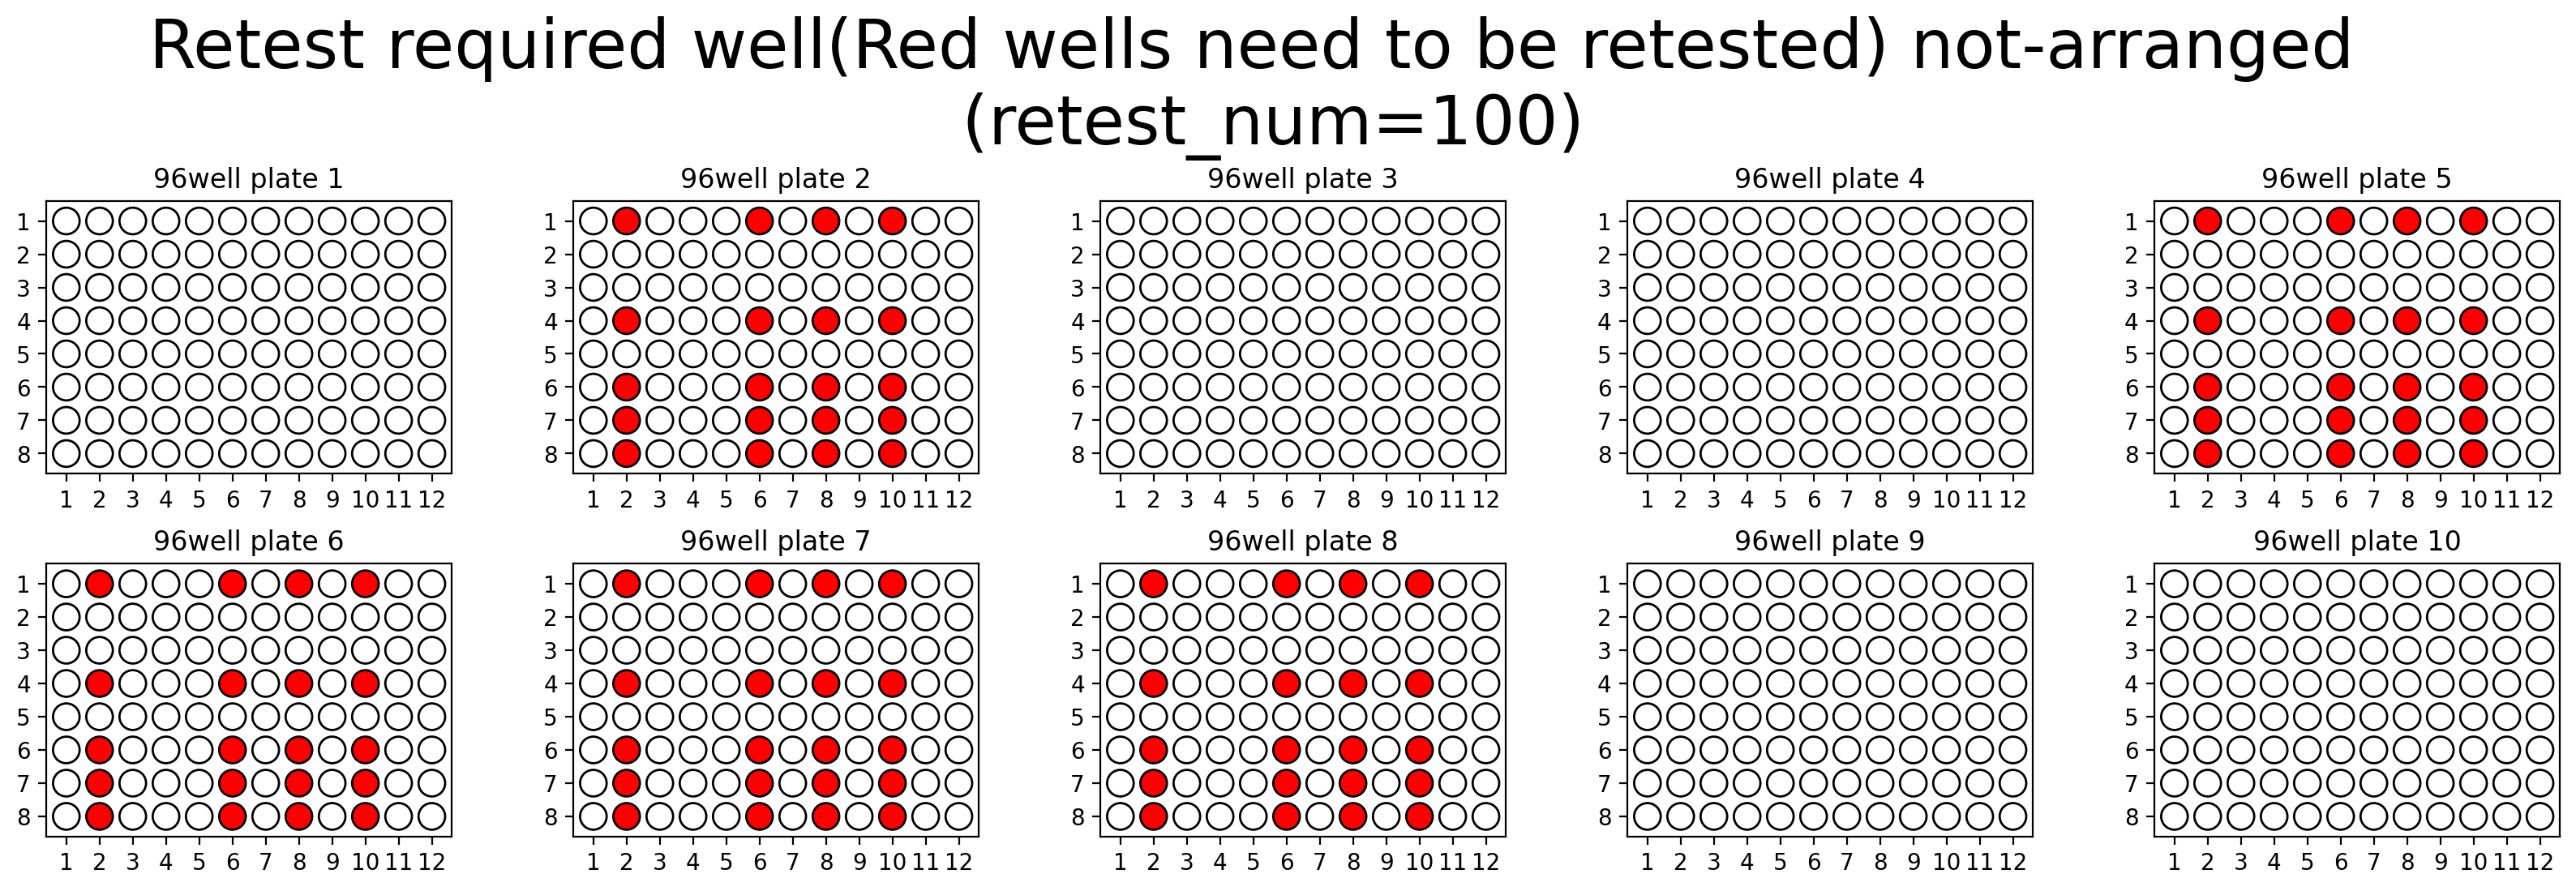

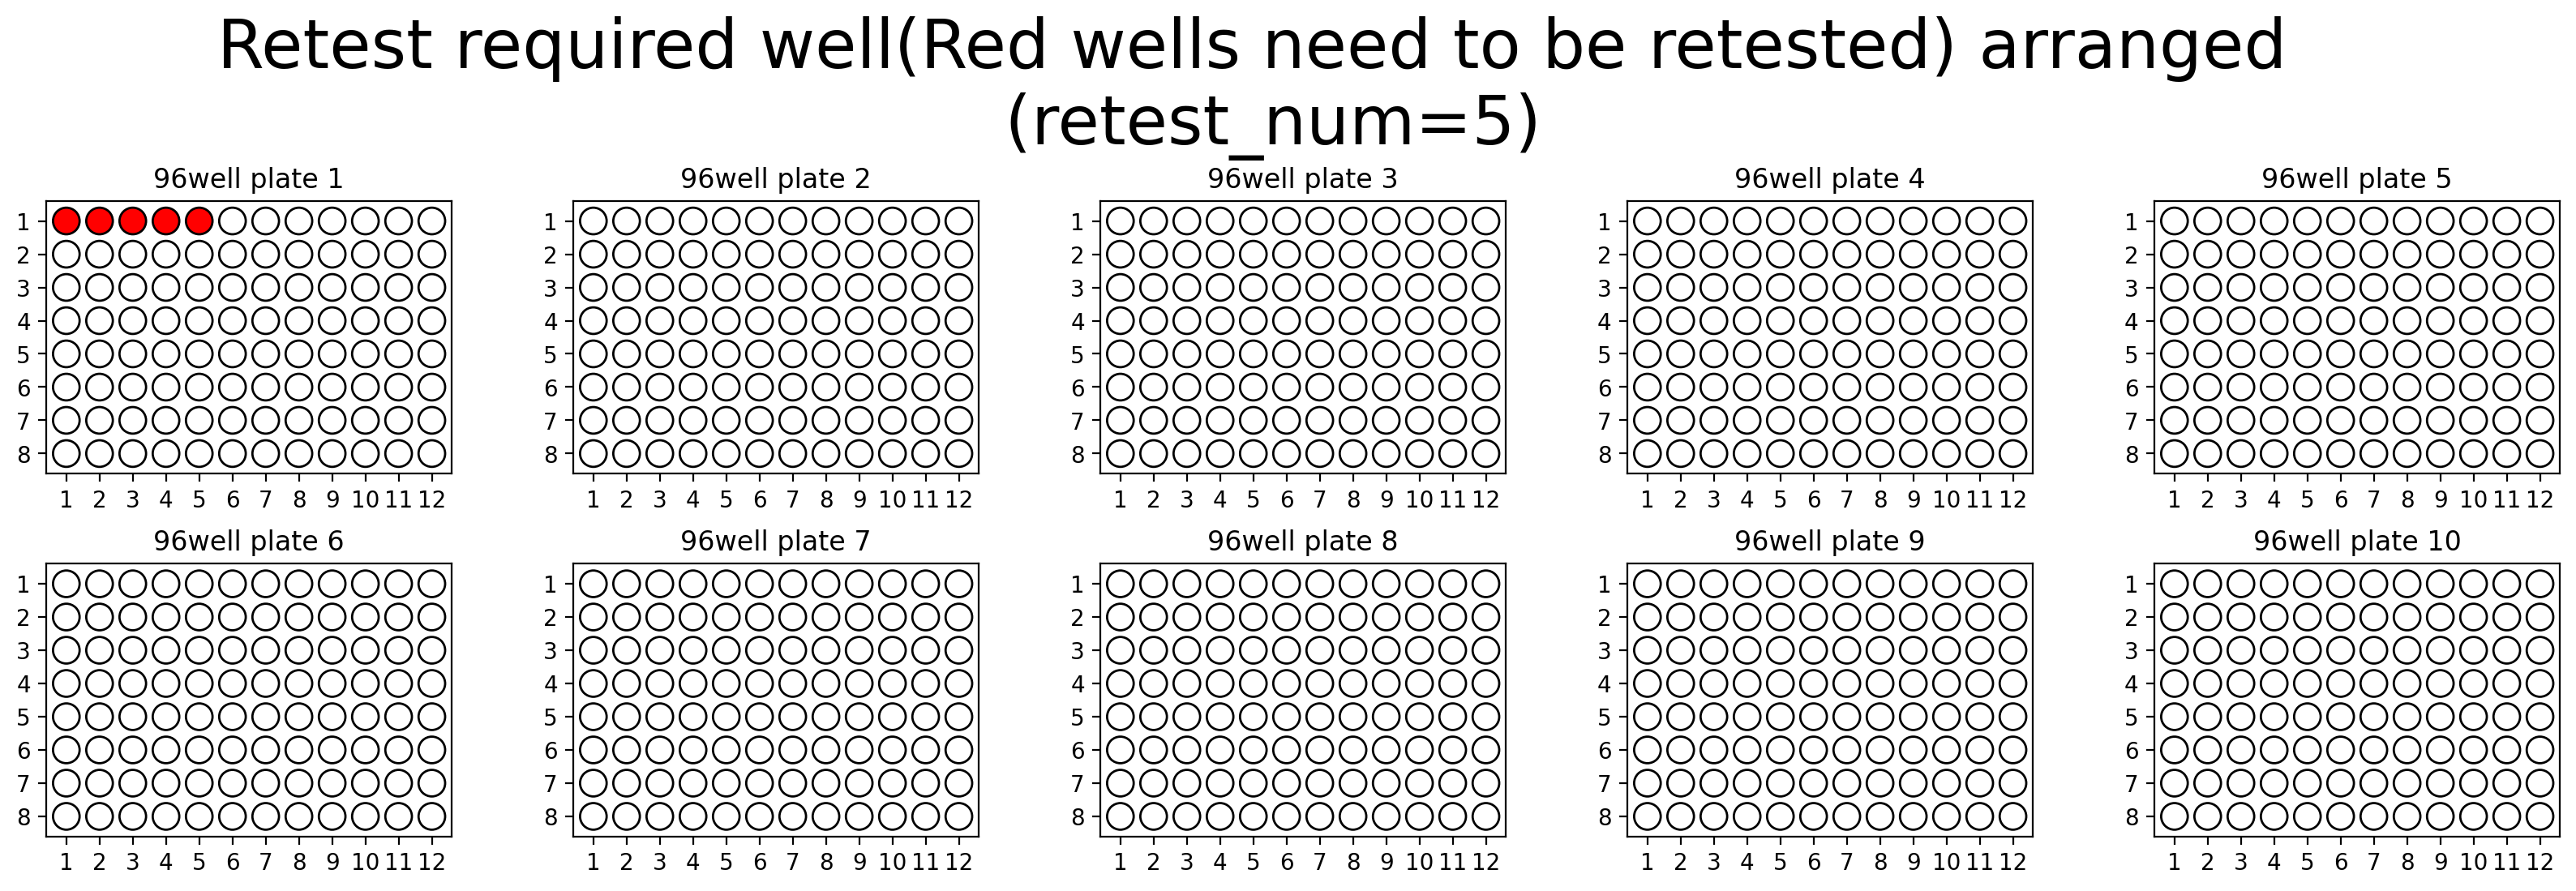

In [137]:
positive_index = np.random.choice(960, 5, replace=False)

positive_index = np.unravel_index(positive_index, (12, 8, 10))

plates = np.zeros(sample_size)
plates[positive_index] = 1

arranged_plates = np.zeros(sample_size)
arranged_plates[:5, 0, 0] = 1

visualizer(plates, title=f'Retest required well(Red wells need to be retested) not-arranged \n (retest_num={calculate_positive_indices(plates)})')
visualizer(arranged_plates, title=f'Retest required well(Red wells need to be retested) arranged \n (retest_num={calculate_positive_indices(arranged_plates)})')

0
1
2
b
10000 10000
a
680972 563838
a
3592533 2662236


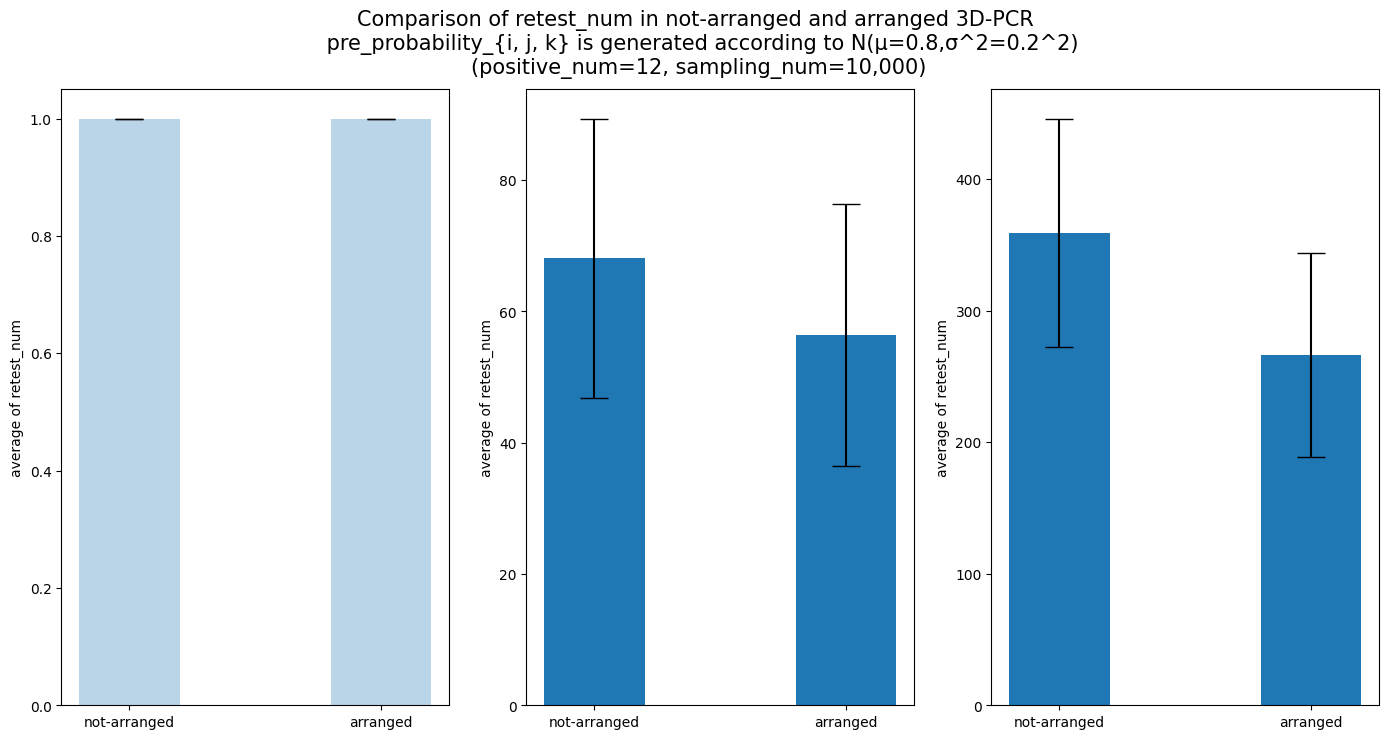

In [182]:
result_2_pure = [] # densityごとに区切っている
result_2_arranged = []
cases = [1, 5, 12]
mu, sigma = 0.8, 0.2

for data_density in range(len(cases)):
# for data_density in range(1, 2):
    temp_pure = []
    temp_arranged = []
    # fix seed
    np.random.seed(0)
    for _ in range(shot_num):
        positive_index = np.random.choice(960, cases[data_density], replace=False)
        
        # print('a', len(positive_index)) if len(positive_index) != cases[data_density] else None, ok
        
        positive_index = np.unravel_index(positive_index, (12, 8, 10))

        # print(len(positive_index)) if len(positive_index) != 3 else None, ok
        # print('a', len(positive_index)) if len(positive_index) != cases[data_density] else None, ok
        
        plates = np.zeros(sample_size)
        plates[positive_index] = 1

        # print(len(np.nonzero(plates)[0]), positive_index) if len(np.nonzero(plates)[0]) != cases[data_density] else None, ok
              
        temp_pure.append(calculate_positive_indices(plates))
        # print(temp_pure[-1]) if cases[data_density] == 1 and temp_pure[-1] != 1 else None, ok

        pre_probability_layer = np.random.normal(mu, sigma, sampling_num)
        pre_probability_layer = pre_probability_layer[(pre_probability_layer >= 0) & (pre_probability_layer <= 1)]
        pre_probability_layer = pre_probability_layer[:960].reshape(sample_size)
        
        random_matrix = np.random.random(sample_size)
        
        mask = random_matrix < pre_probability_layer
        pseudo_plates = np.where(mask, plates, 1 - plates)

        pre_probability_list = pre_probability_layer.ravel().tolist()
        psudo_plates_list = pseudo_plates.ravel().tolist()
        plates_list = plates.ravel().tolist()

        # print(sum(plates_list)) if sum(plates_list) != cases[data_density] else None, ok
        
        pseudo_plates_plates_list = [(psudo_plates_list[i], plates_list[i]) for i in range(len(psudo_plates_list))]
        pseudo_plates_plates_list.sort(key=lambda x: x[0], reverse = True)

        arranged_plates = [pseudo_plates_plates_list[i][1] for i in range(len(pseudo_plates_plates_list))]
        
        # print(sum(arranged_plates)) if sum(arranged_plates) != cases[data_density] else None, ok
        
        arranged_plates = np.array(arranged_plates).reshape(10, 8, 12).transpose(2, 1, 0)
        
        print(len(np.nonzero(arranged_plates)[0])) if len(np.nonzero(arranged_plates)[0]) != cases[data_density] else None
        # check upper bound and lower bound
        print('a', len(np.nonzero(arranged_plates)[0])) if not(cases[data_density] <= calculate_positive_indices(arranged_plates) <= min(cases[data_density], 12) * min(cases[data_density], 8), min(cases[data_density], 10)) else None
        
        temp_arranged.append(calculate_positive_indices(arranged_plates))
    print(data_density)
    result_2_pure.append(temp_pure)
    result_2_arranged.append(temp_arranged)

# visualize
fig = plt.figure(figsize=(17, 8))

for i in range(len(result_2_pure)):
    ax = fig.add_subplot(1, 3, i+1)
    
    mean_pure, mean_arranged = np.mean(result_2_pure[i]), np.mean(result_2_arranged[i])
    std_pure, std_arranged = np.std(result_2_pure[i]), np.std(result_2_arranged[i])
    if check_significant_difference(result_2_pure[i], result_2_arranged[i]):
        print('a')
        alpha = 1.0
    else:
        print('b')
        alpha = 0.3

    ax.bar(0, mean_pure, yerr=std_pure, capsize=10, color='#1f77b4', alpha=alpha)
    ax.bar(2, mean_arranged, yerr=std_arranged, capsize=10, color='#1f77b4', alpha=alpha)
    
    print(sum(result_2_pure[i]), sum(result_2_arranged[i]))
    # ax.set_xlabel('Comparison of not-arranged and arranged')

    ticks_location = [0, 2]  # この位置に目盛りを設定
    labels = ['not-arranged', 'arranged']   # このラベルを表示

    ax.set_xticks(ticks_location)
    ax.set_xticklabels(labels)
    # ax.set_title(f'Simulation results of {shot_num} times (μ={mu},σ={sigma})')
    ax.set_ylabel('average of retest_num')
    ax.ticklabel_format(style='plain',axis='y')
fig.suptitle('Comparison of retest_num in not-arranged and arranged 3D-PCR \n pre_probability_{i, j, k} is generated according to ' + f'N(μ={mu},σ^2={sigma}^2)\n' + f'(positive_num={cases[data_density]}, sampling_num={shot_num:,})', size=15)

fig.show()

0

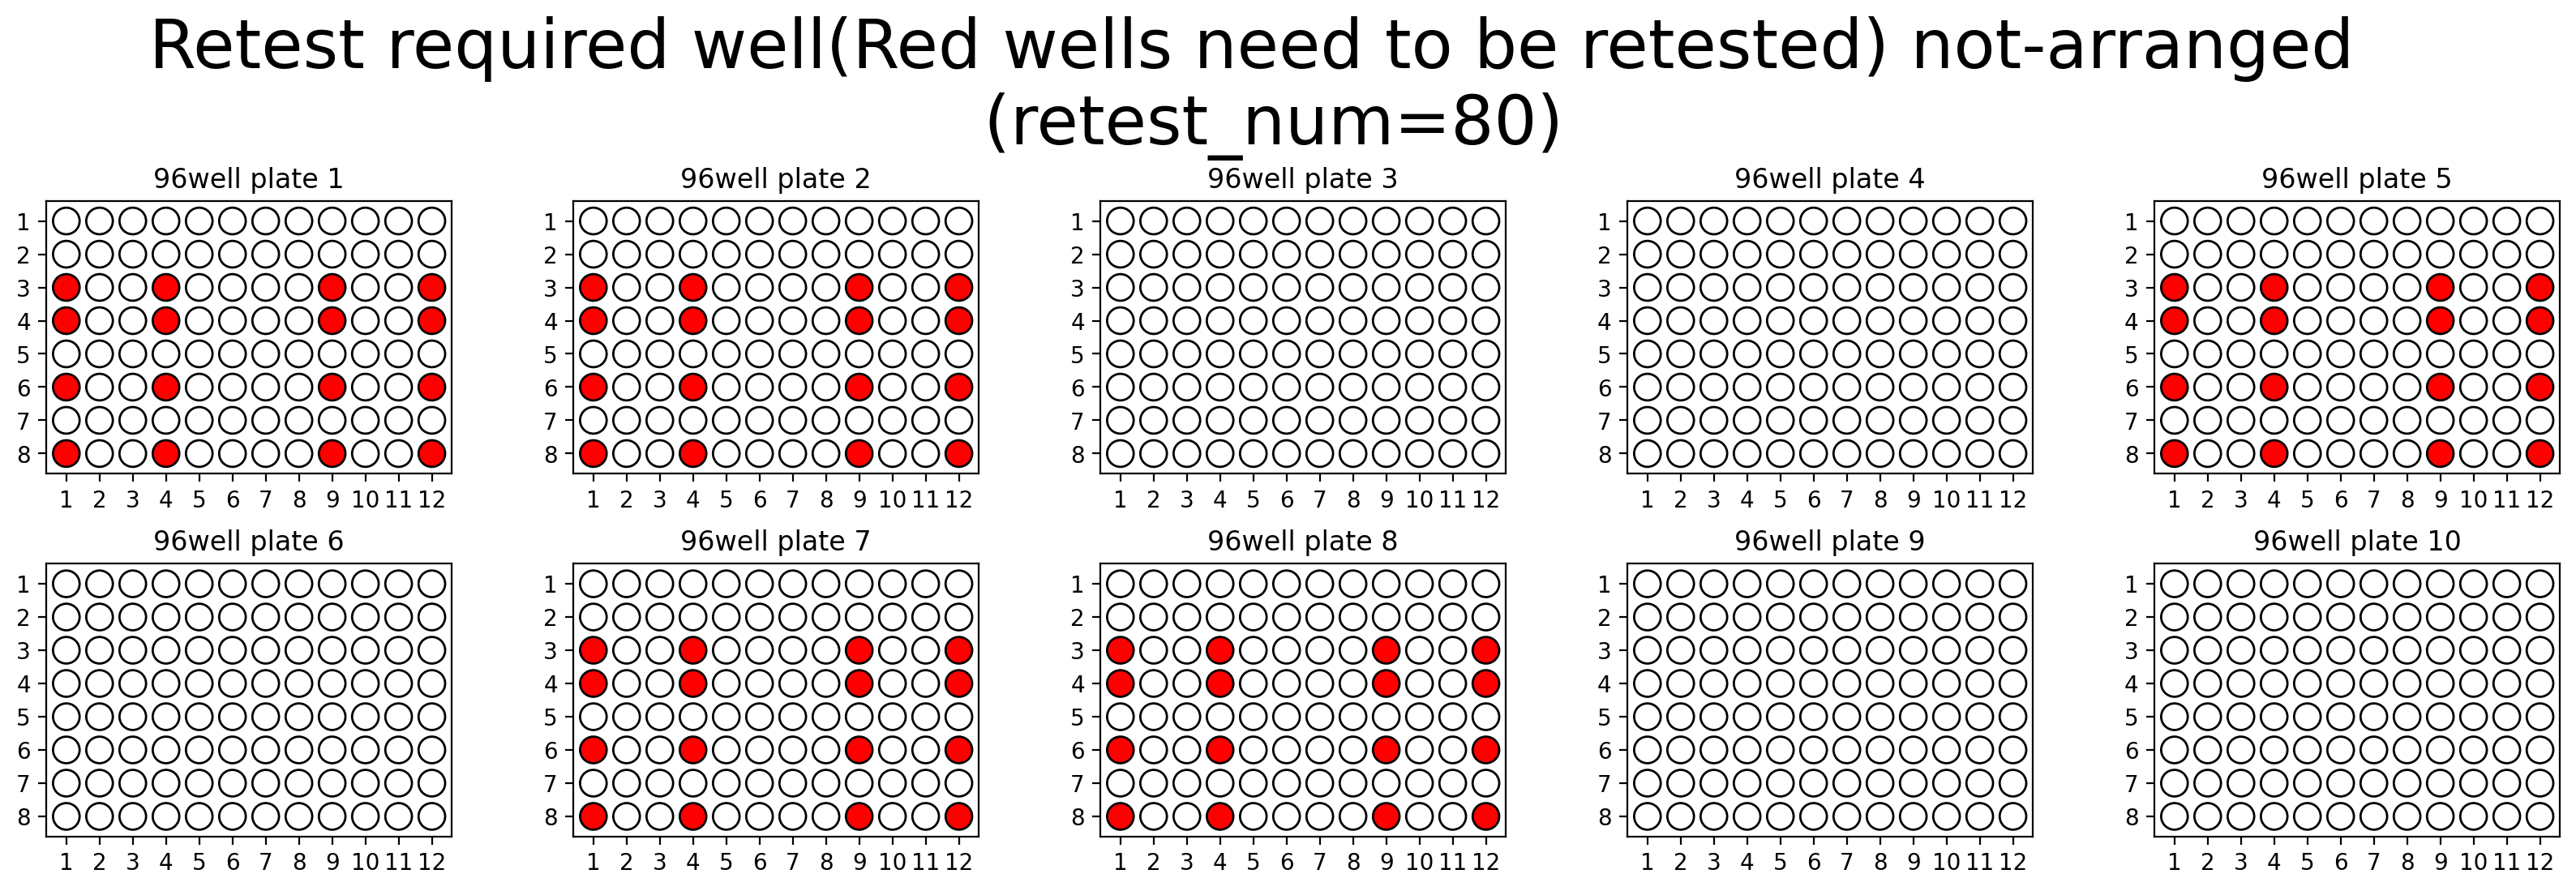

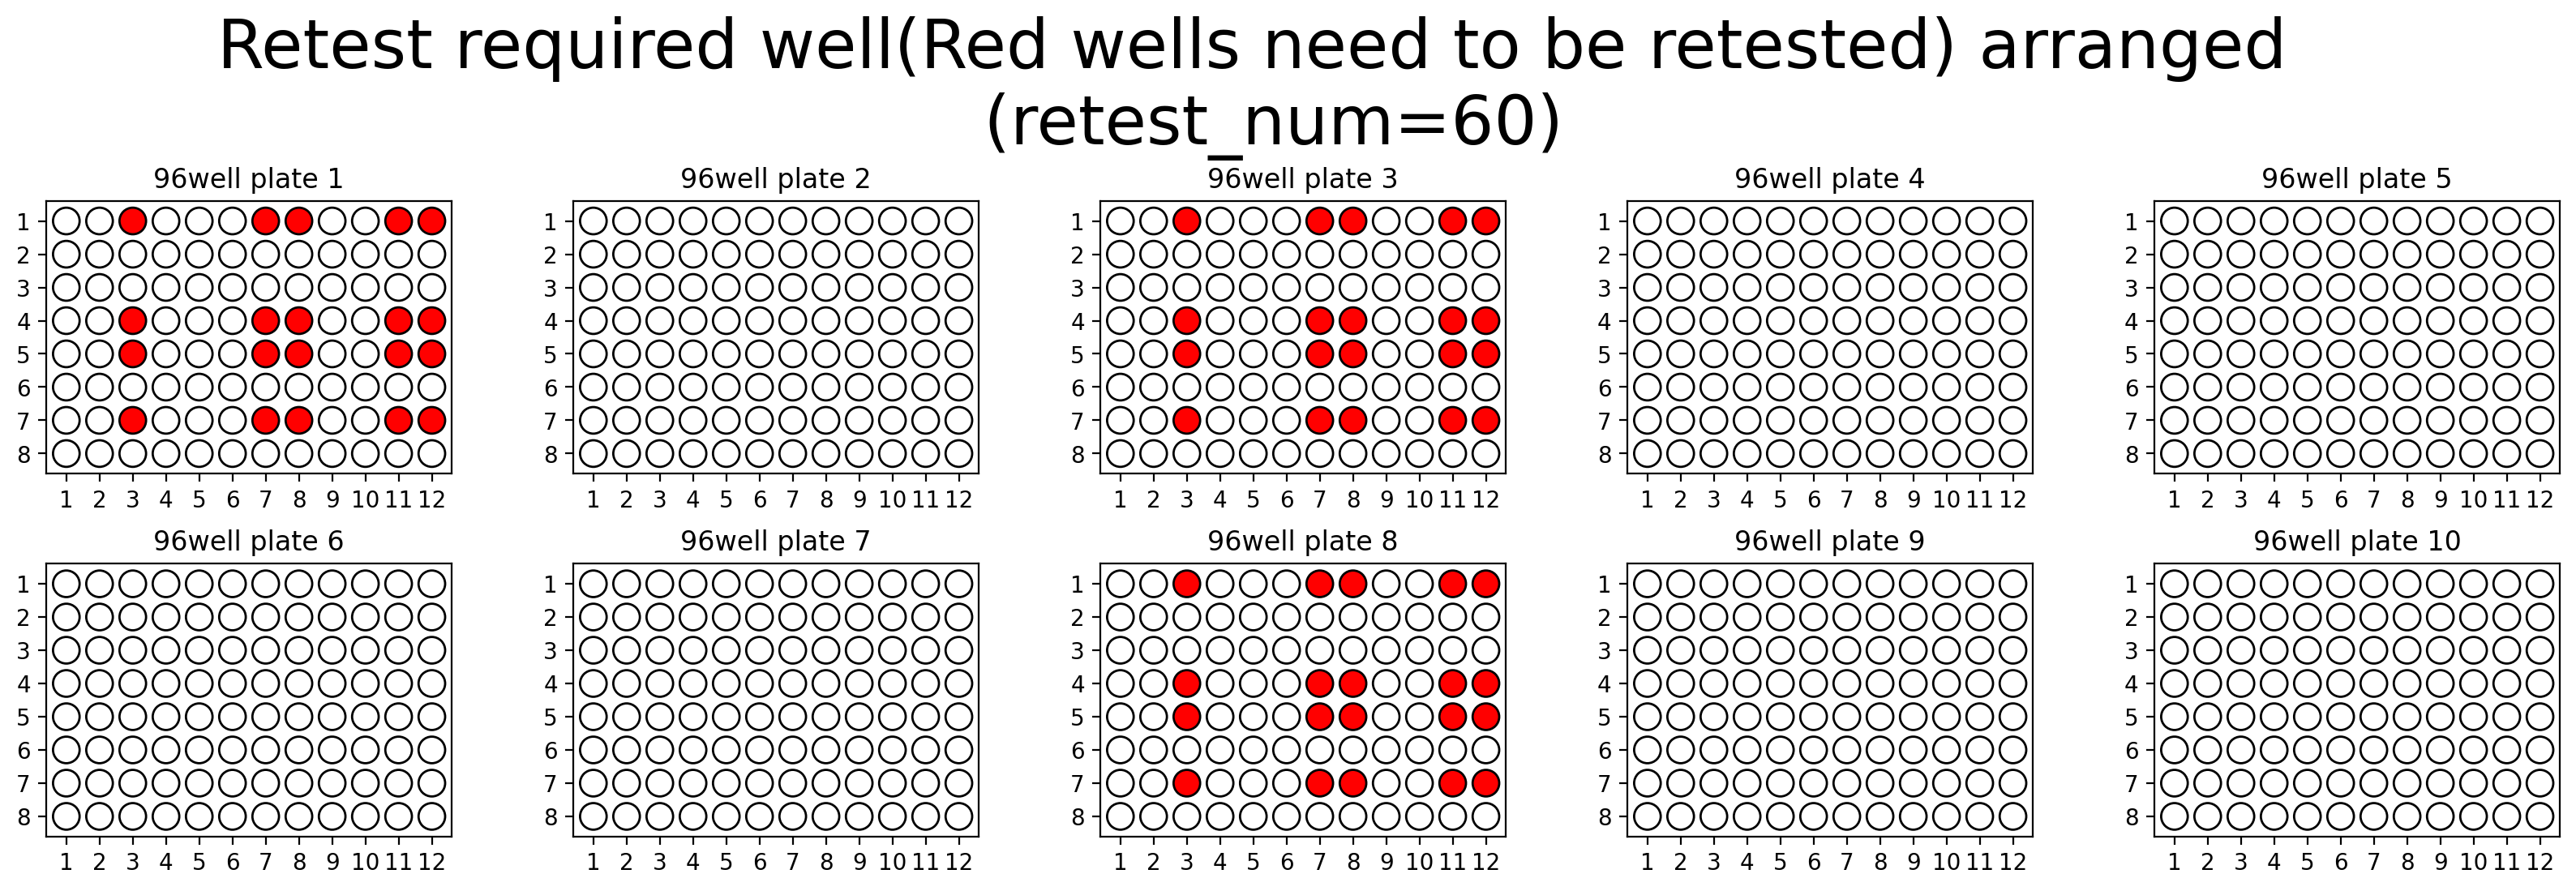

In [157]:
visualizer(plates, title=f'Retest required well(Red wells need to be retested) not-arranged \n (retest_num={calculate_positive_indices(plates)})')
visualizer(arranged_plates, title=f'Retest required well(Red wells need to be retested) arranged \n (retest_num={calculate_positive_indices(arranged_plates)})')

## case-3

/tmp/ipykernel_20/1715164361.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_int, rotation=45, size=10)


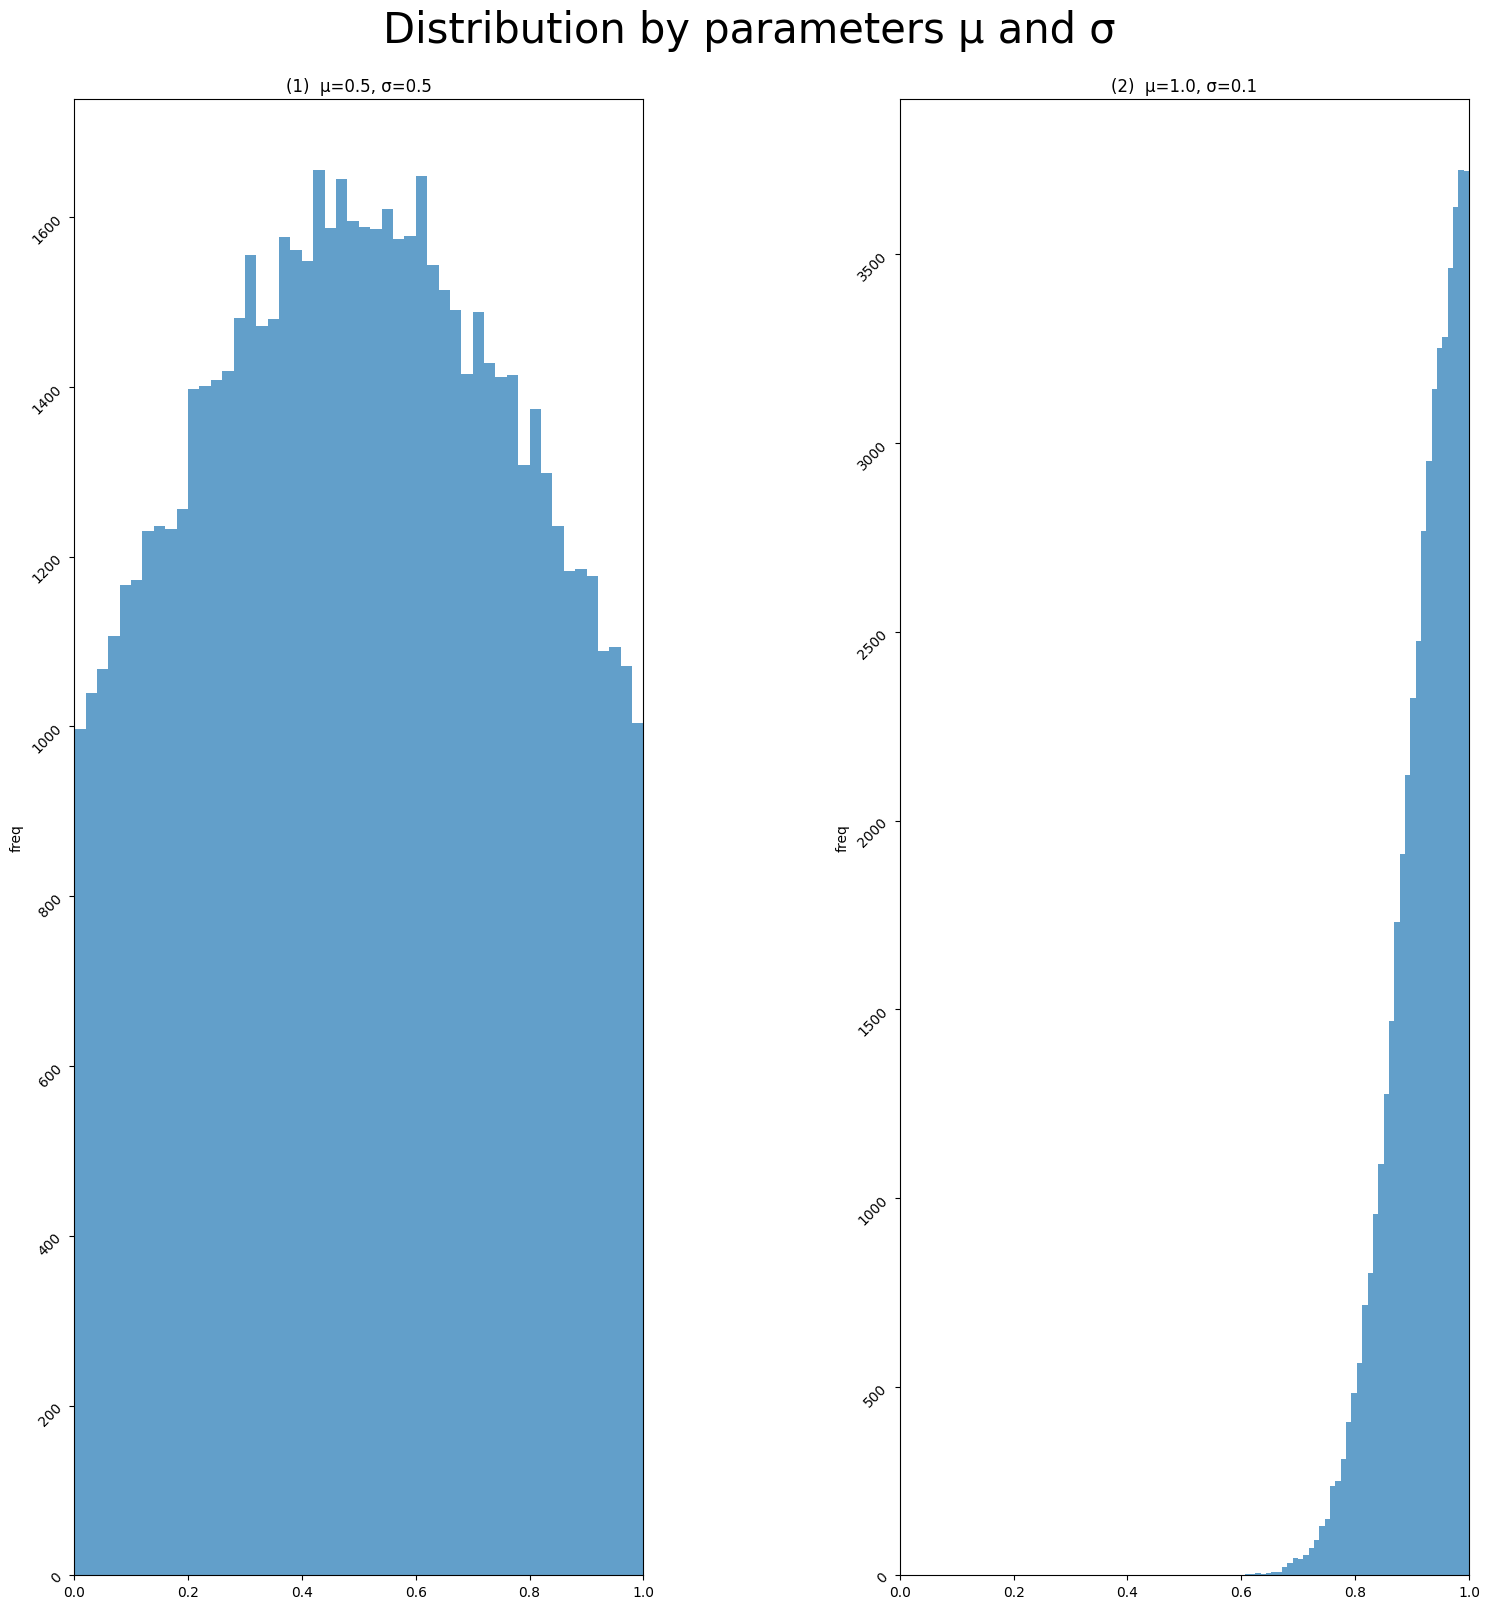

In [165]:
# means = [round(i*0.2, 2) for i in range(0, 6)]
# std_devs = [round(i*0.1, 2) for i in range(1, 7)]
# params = list(itertools.product(means, std_devs))
params = [(0.5, 0.5), (1.0, 0.1)]
sampling_num = 100000

hidden_probability_list = []

fig = plt.figure(figsize=(18, 18))

# fix seed
np.random.seed(0)
for i in range(len(params)):
    mu, sigma = params[i]
    samples = np.random.normal(mu, sigma, sampling_num)
    samples = samples[(samples >= 0) & (samples <= 1)]
    # ax = fig.add_subplot(6, 6, i+1)
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(samples, bins=50, alpha=0.7)
    ax.set_xlim(0, 1)
    ax.set_title(f'({i+1})  μ={mu}, σ={sigma}')
    
    yticks_int = [int(y) for y in ax.get_yticks()]
    ax.set_yticklabels(yticks_int, rotation=45, size=10)
    ax.set_ylabel('freq')
    
    hidden_probability_list.append(samples[:12*8*10].reshape((12, 8, 10)))

fig.suptitle('Distribution by parameters μ and σ', size=30)
fig.subplots_adjust(wspace=0.45, hspace=0.3, top=0.93)
fig.show()

In [166]:
result_3_pure_list = []
result_3_arranged_list = []

cost_3_pure_list = []
cost_3_pure_list = []
cases = [1, 5, 12]

for data_density in range(len(cases)):
    result_3_pure = []
    result_3_arranged = []

    cost_3_pure = []
    cost_3_arranged = []
    
    for i in range(len(hidden_probability_list)):
        temp_pure = []
        temp_arranged = []
        
        # fix seed
        np.random.seed(0)
        for _ in range(shot_num):
            positive_index = np.random.choice(960, cases[data_density], replace=False)
            
            # print('error', len(positive_index)) if len(positive_index) != cases[data_density] else None, ok
            
            positive_index = np.unravel_index(positive_index, (12, 8, 10))
    
            # print(len(positive_index)) if len(positive_index) != 3 else None, ok
            # print('a', len(positive_index)) if len(positive_index) != cases[data_density] else None, ok
            
            plates = np.zeros(sample_size)
            plates[positive_index] = 1
    
            # print(len(np.nonzero(plates)[0]), positive_index) if len(np.nonzero(plates)[0]) != cases[data_density] else None, ok
    
            # print(temp_pure[-1]) if cases[data_density] == 1 and temp_pure[-1] != 1 else None, ok
            
            pre_probability_layer = hidden_probability_list[i]
            random_matrix = np.random.random(sample_size)
            mask = random_matrix < pre_probability_layer
            pseudo_plates = np.where(mask, plates, 1 - plates)
    
            pre_probability_list = pre_probability_layer.ravel().tolist()
            psudo_plates_list = pseudo_plates.ravel().tolist()
            plates_list = plates.ravel().tolist()
    
            # print(sum(plates_list)) if sum(plates_list) != cases[data_density] else None, ok
            
            pseudo_plates_plates_list = [(psudo_plates_list[i], plates_list[i]) for i in range(len(psudo_plates_list))]
            pseudo_plates_plates_list.sort(key=lambda x: x[0], reverse = True)
    
            arranged_plates = [pseudo_plates_plates_list[i][1] for i in range(len(pseudo_plates_plates_list))]
            
            # print(sum(arranged_plates)) if sum(arranged_plates) != cases[data_density] else None, ok
            
            arranged_plates = np.array(arranged_plates).reshape(10, 8, 12).transpose(2, 1, 0)
            
            print(len(np.nonzero(arranged_plates)[0])) if len(np.nonzero(arranged_plates)[0]) != cases[data_density] else None
            # check upper bound and lower bound
            print('retest_num is too much', len(np.nonzero(arranged_plates)[0])) if not(cases[data_density] <= calculate_positive_indices(arranged_plates) <= min(cases[data_density], 12) * min(cases[data_density], 8), min(cases[data_density], 10)) else None
    
            temp_pure.append(calculate_positive_indices(plates))
            temp_arranged.append(calculate_positive_indices(arranged_plates))

            
    
        result_3_pure.append(temp_pure)
        result_3_arranged.append(temp_arranged)

    result_3_pure_list.append(result_3_pure)
    result_3_arranged_list.append(result_3_arranged)

In [86]:
# fig = plt.figure(figsize=(24, 24))

# for i in range(len(hidden_probability_list)):
#     ax = fig.add_subplot(6, 6, i+1)
#     ax.bar([0, 2], [sum(result_3_pure[i]), sum(result_3_arranged[i])], alpha=0.7)
#     # print(sum(result_3_pure[i]), sum(result_3_arranged[i])) if sum(result_3_pure[i]) != sum(result_3_arranged[i]) else None
#     ticks_location = [0, 2]  # この位置に目盛りを設定
#     labels = ['not-arranged', 'arranged']   # このラベルを表示

#     ax.set_title(f'({i+1})  μ={params[i][0]}, σ={params[i][1]}')
#     ax.set_xticks(ticks_location)
#     ax.set_xticklabels(labels)
#     # ax.set_title(f'Simulation results of {shot_num} times')

#     ax.ticklabel_format(style='plain',axis='y')

# fig.subplots_adjust(wspace=0.3, hspace=0.3)
# fig.suptitle(f'Comparison of not-arranged and arranged(positive_num={cases[data_density]}, sampling_num=100,000)')
# fig.show()

# Comparison of retest_num in not-arranged and arranged 3D-PCR

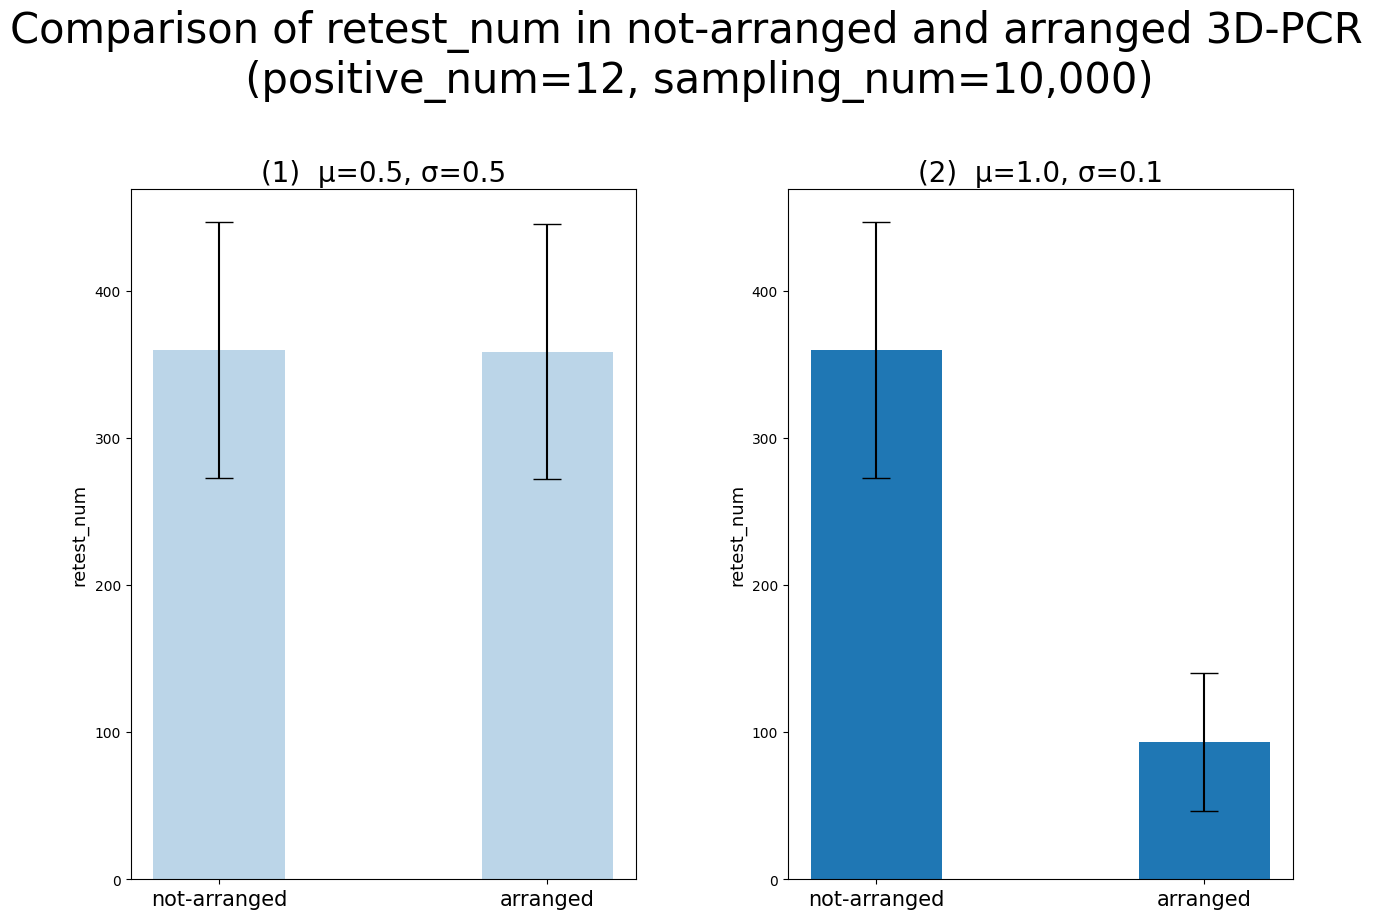

In [180]:
data_density = 2

result_3_pure = result_3_pure_list[data_density]
result_3_arranged = result_3_arranged_list[data_density]

# fig = plt.figure(figsize=(24, 24))
fig = plt.figure(figsize=(15, 10))
mean_improvement = []

for i in range(len(hidden_probability_list)):
    # ax = fig.add_subplot(6, 6, i+1)
    ax = fig.add_subplot(1, 2, i+1)

    mean_pure, mean_arranged = np.mean(result_3_pure[i]), np.mean(result_3_arranged[i])
    std_pure, std_arranged = np.std(result_3_pure[i]), np.std(result_3_arranged[i])

    mean_improvement.append((mean_pure, mean_arranged))
    # print('error') if ~np.all(mean_pure) else None
    
    if check_significant_difference(result_3_pure[i], result_3_arranged[i]):
        alpha = 1.0
    else:
        alpha = 0.3

    ax.bar(0, mean_pure, yerr=std_pure, capsize=10, color='#1f77b4', alpha=alpha)
    ax.bar(2, mean_arranged, yerr=std_arranged, capsize=10, color='#1f77b4', alpha=alpha)


    ticks_location = [0, 2]  # この位置に目盛りを設定
    labels = ['not-arranged', 'arranged']   # このラベルを表示

    
    ax.set_title(f'({i+1})  μ={params[i][0]}, σ={params[i][1]}', size=20)
    ax.set_xticks(ticks_location)
    ax.set_xticklabels(labels, size=15)
    ax.set_ylabel('retest_num', size=13)
    # ax.set_yticklabels(ax.get_yticks(), rotation=45, size=10)
    # ax.set_title(f'Simulation results of {shot_num} times')

    ax.ticklabel_format(style='plain',axis='y')

fig.suptitle(f'Comparison of retest_num in not-arranged and arranged 3D-PCR \n (positive_num={cases[data_density]}, sampling_num={shot_num:,})', size=30)
fig.subplots_adjust(wspace=0.3, hspace=0.3, top=0.8)
fig.show()

# Improvement rate of retest_num(%)

In [14]:
mean_improvement_retest_num_dict = defaultdict()

for data_density in range(3):
    result_3_pure = result_3_pure_list[data_density]
    result_3_arranged = result_3_arranged_list[data_density]
    mean_improvement_retest_num = []

    for i in range(len(hidden_probability_list)):
        mean_pure, mean_arranged = np.mean(result_3_pure[i]), np.mean(result_3_arranged[i])
        mean_improvement_retest_num.append((mean_pure, mean_arranged))
    mean_improvement_retest_num_dict[cases[data_density]] = mean_improvement_retest_num

improvement_rates_retest_num_list = []
for key in mean_improvement_retest_num_dict.keys():
    # print(mean_improvement_dict[key])
    mean_improved = mean_improvement_retest_num_dict[key]
    improvement_rates_retest_num_list.append((key, np.array([(mean_improved[i][0] - mean_improved[i][1]) / mean_improved[i][0] * 100 for i in range(len(mean_improved))]).reshape((6, 6))))
improvement_rates_retest_num_list.sort(key=lambda x: x[0])
improvement_rates_retest_num_list = [improvement_rates_retest_num_list[i][1] for i in range(len(improvement_rates_retest_num_list))]

improvement_rates_retest_num = np.dstack((improvement_rates_retest_num_list[0], improvement_rates_retest_num_list[1], improvement_rates_retest_num_list[2]))

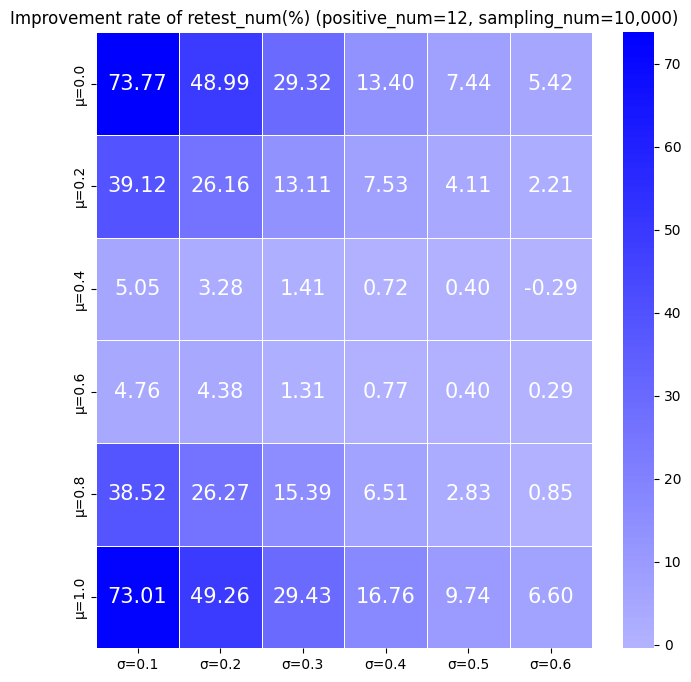

In [18]:
data_density = 2

global_min = improvement_rates_retest_num.min()
global_max = improvement_rates_retest_num.max()

colors = [(0, 0, 1, 0.3), (0, 0, 1, 1)]  # (R, G, B, alpha)
cmap_name = 'custom_div_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(8, 8))
sns.heatmap(improvement_rates_retest_num[:, :, data_density], annot=improvement_rates_retest_num[:, :, data_density], fmt=".2f", cmap=cm, vmin=global_min, vmax=global_max,
            linewidths=0.5, linecolor='white', cbar=True, annot_kws={"color": 'white', 'size': 15})

positions = np.array([0, 1, 2, 3, 4, 5])  + 0.5
plt.xticks(positions, [f'σ={std_devs[i]}' for i in range(len(std_devs))])
plt.yticks(positions, [f'μ={means[i]}' for i in range(len(means))])

plt.title(f'Improvement rate of retest_num(%) (positive_num={cases[data_density]}, sampling_num={shot_num:,})')
plt.show()

# Comparison of testing cost in not-arranged and arranged 3D-PCR

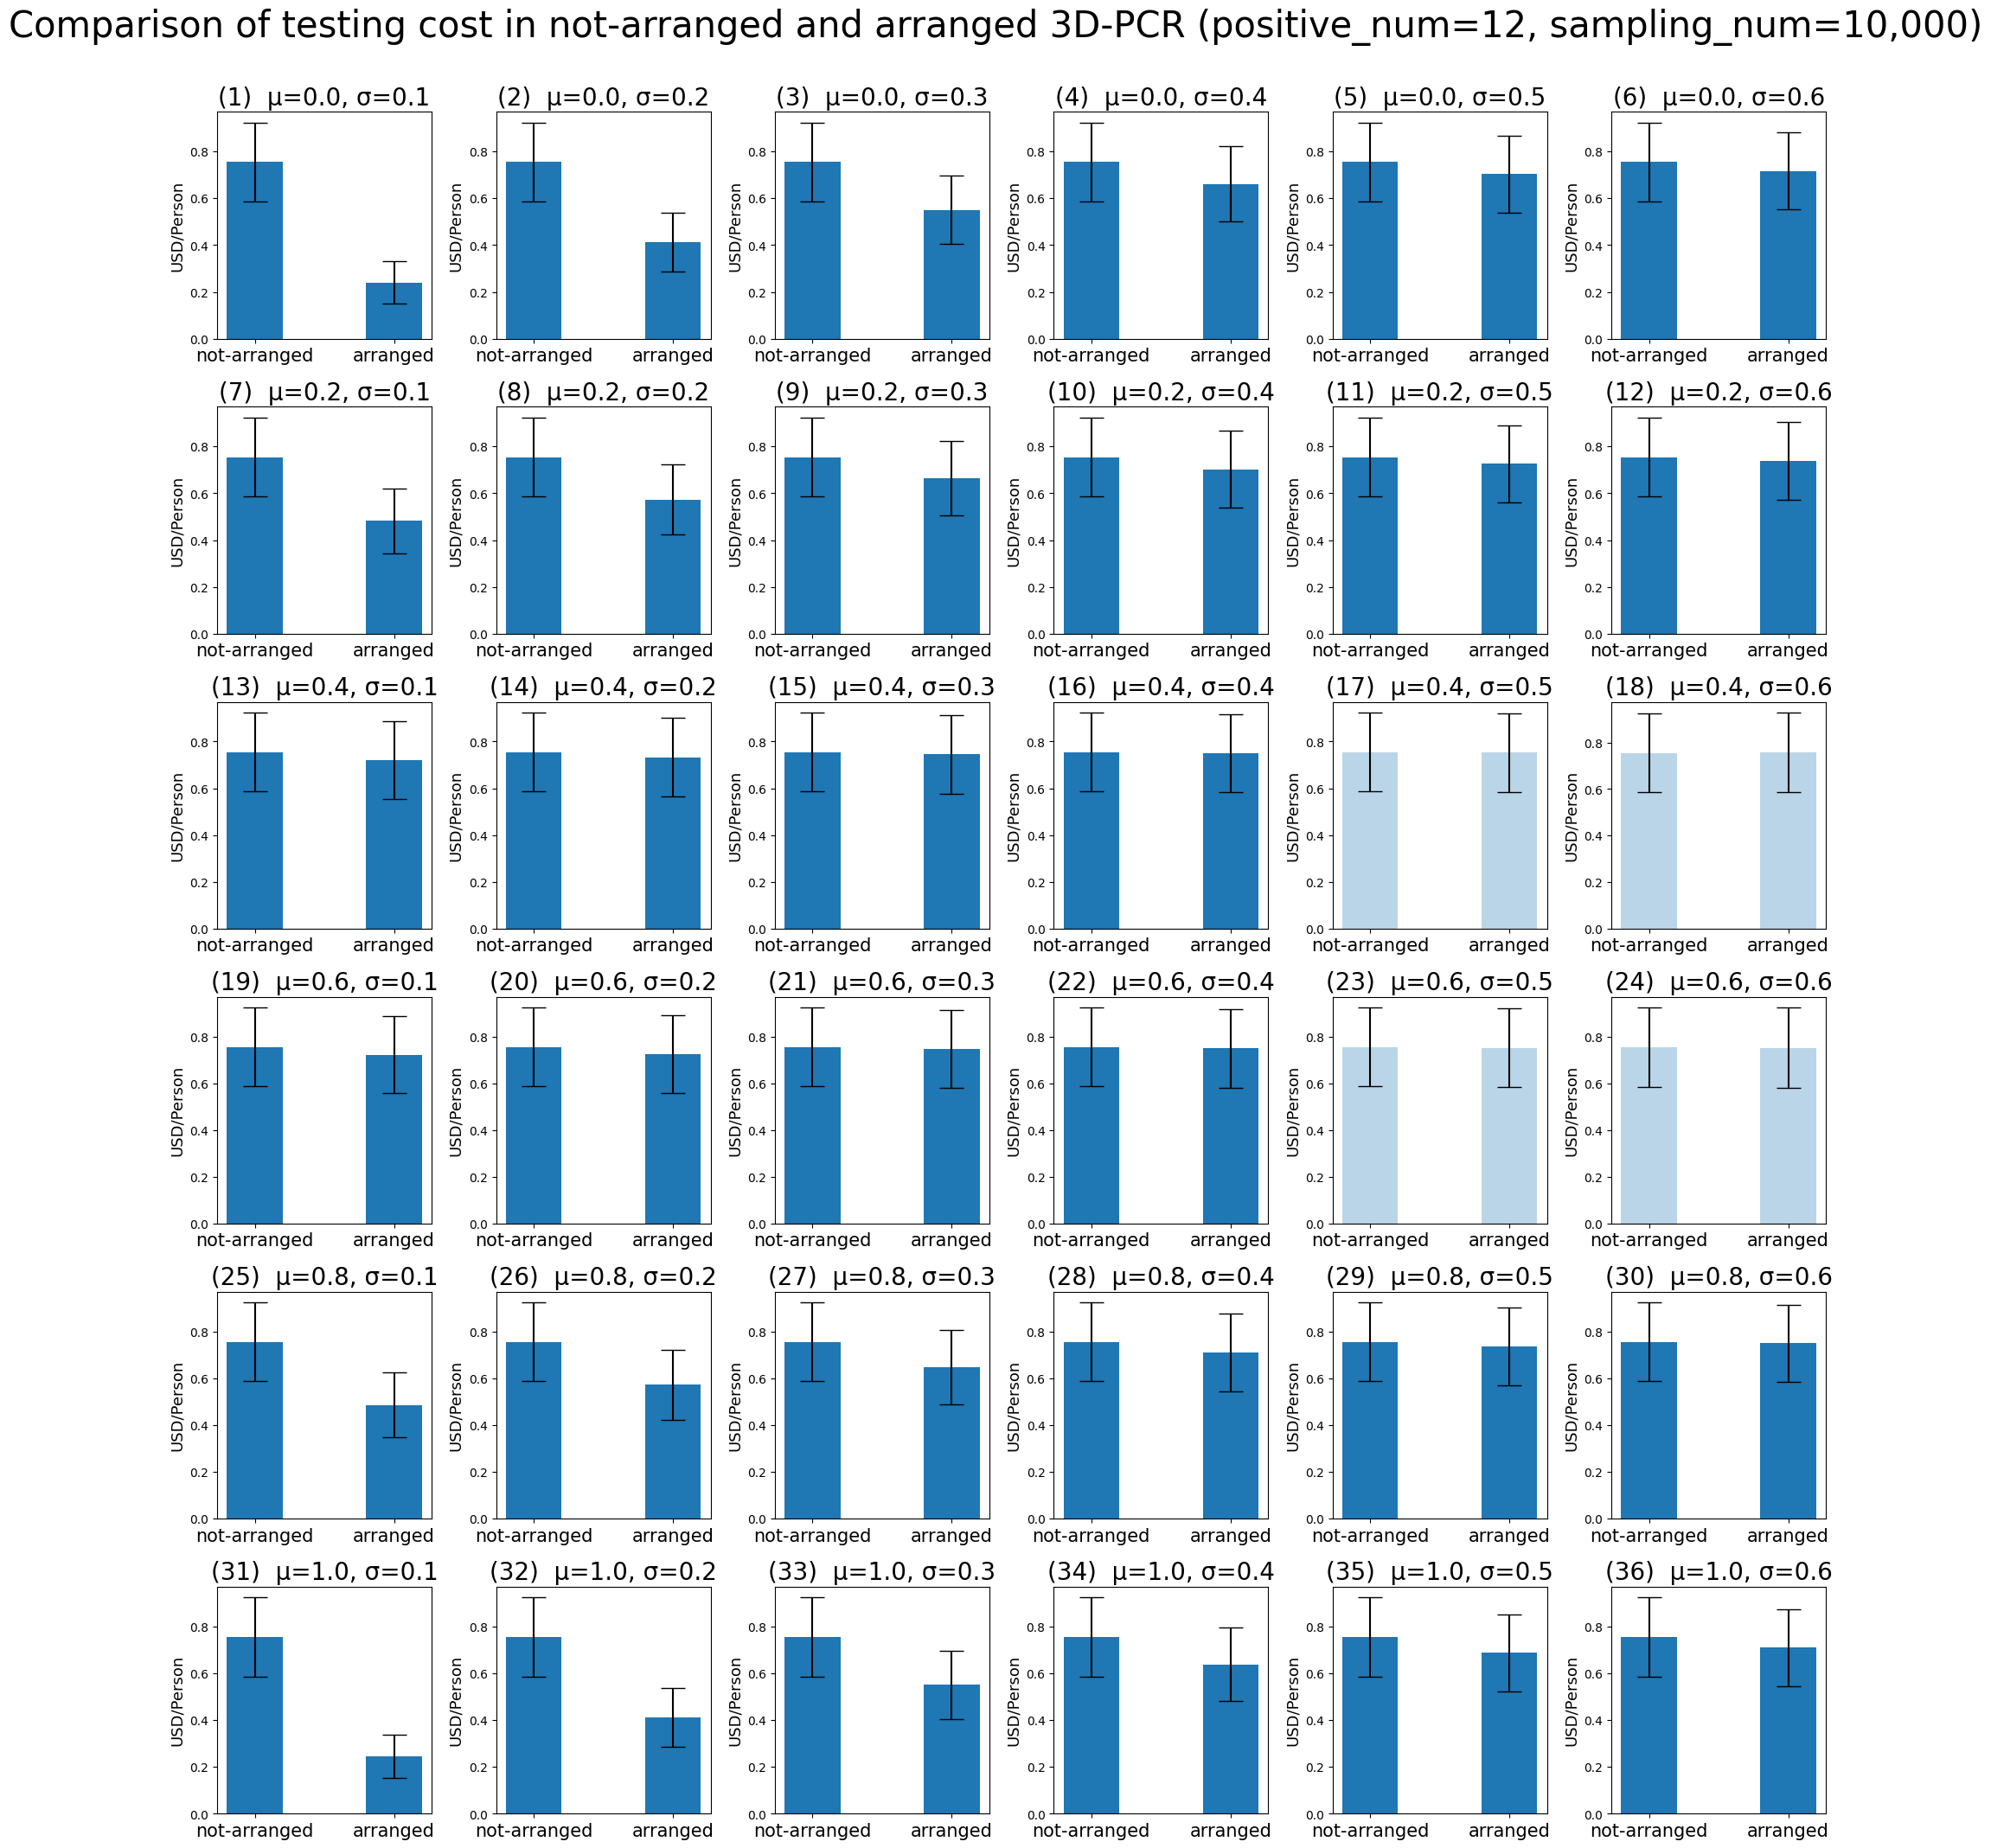

In [24]:
data_density = 2

# result_3_pure = result_3_pure_list[data_density]
# result_3_arranged = result_3_arranged_list[data_density]
cost_pure = (8283 + np.array(result_3_pure_list) * 277) / 960 / 149
cost_arranged = (8283 + np.array(result_3_arranged_list) * 277) / 960 / 149
cost_pure = cost_pure[data_density, :, :].tolist()
cost_arranged = cost_arranged[data_density, :, :].tolist()

fig = plt.figure(figsize=(24, 24))
mean_improvement = []

for i in range(len(hidden_probability_list)):
    ax = fig.add_subplot(6, 6, i+1)

    cost_mean_pure, cost_mean_arranged = np.mean(cost_pure[i]), np.mean(cost_arranged[i])
    cost_std_pure, cost_std_arranged = np.std(cost_pure[i]), np.std(cost_arranged[i])

    mean_improvement.append((cost_mean_pure, cost_mean_arranged))
    # print('error') if ~np.all(cost_mean_pure) else None

    # if check_significant_difference(result_3_pure[i], result_3_arranged[i]):
    if check_significant_difference(cost_pure[i], cost_arranged[i]):
        alpha = 1.0
    else:
        alpha = 0.3

    ax.bar(0, cost_mean_pure, yerr=cost_std_pure, capsize=10, color='#1f77b4', alpha=alpha)
    ax.bar(2, cost_mean_arranged, yerr=cost_std_arranged, capsize=10, color='#1f77b4', alpha=alpha)


    ticks_location = [0, 2]  # この位置に目盛りを設定
    labels = ['not-arranged', 'arranged']   # このラベルを表示

    ax.set_ylabel('USD/Person', size=13)
    ax.set_title(f'({i+1})  μ={params[i][0]}, σ={params[i][1]}', size=20)
    ax.set_xticks(ticks_location)
    ax.set_xticklabels(labels, size=15)
    # ax.set_title(f'Simulation results of {shot_num} times')

    ax.ticklabel_format(style='plain',axis='y')

fig.suptitle(f'Comparison of testing cost in not-arranged and arranged 3D-PCR (positive_num={cases[data_density]}, sampling_num={shot_num:,})', size=30)
fig.subplots_adjust(wspace=0.3, hspace=0.3, top=0.93)
fig.show()

In [25]:
mean_improvement_cost_dict = defaultdict()

for data_density in range(3):
    cost_pure = (8283 + np.array(result_3_pure_list) * 277) / 960 / 149
    cost_arranged = (8283 + np.array(result_3_arranged_list) * 277) / 960 / 149
    cost_pure = cost_pure[data_density, :, :].tolist()
    cost_arranged = cost_arranged[data_density, :, :].tolist()
    # result_3_pure = result_3_pure_list[data_density]
    # result_3_arranged = result_3_arranged_list[data_density]
    mean_improvement_cost = []

    for i in range(len(hidden_probability_list)):
        mean_pure, mean_arranged = np.mean(cost_pure[i]), np.mean(cost_arranged[i])
        mean_improvement_cost.append((mean_pure, mean_arranged))
    mean_improvement_cost_dict[cases[data_density]] = mean_improvement_cost

improvement_rates_cost_list = []
for key in mean_improvement_cost_dict.keys():
    # print(mean_improvement_dict[key])
    mean_improved = mean_improvement_cost_dict[key]
    improvement_rates_cost_list.append((key, np.array([(mean_improved[i][0] - mean_improved[i][1]) / mean_improved[i][0] * 100 for i in range(len(mean_improved))]).reshape((6, 6))))
improvement_rates_cost_list.sort(key=lambda x: x[0])
improvement_rates_cost_list = [improvement_rates_cost_list[i][1] for i in range(len(improvement_rates_cost_list))]

improvement_rates_cost = np.dstack((improvement_rates_cost_list[0], improvement_rates_cost_list[1], improvement_rates_cost_list[2]))

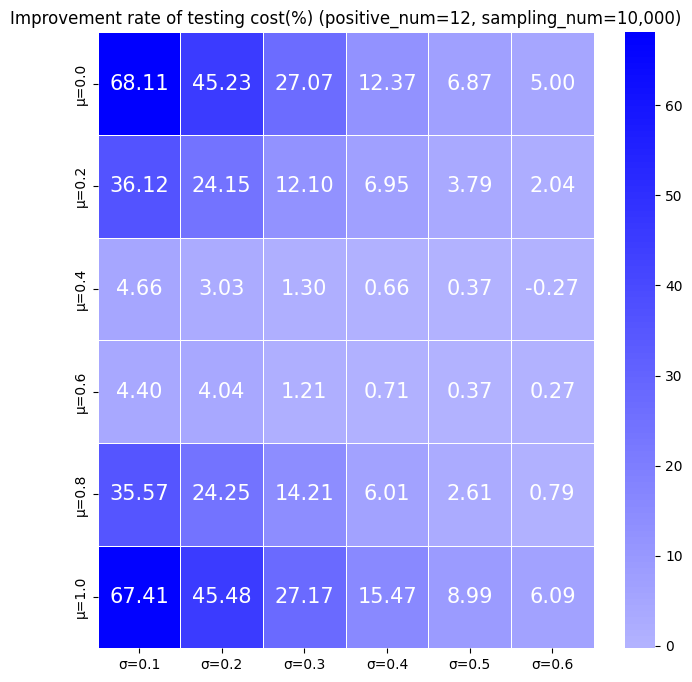

In [28]:
data_density = 2

global_min = improvement_rates_cost.min()
global_max = improvement_rates_cost.max()

colors = [(0, 0, 1, 0.3), (0, 0, 1, 1)]  # (R, G, B, alpha)
cmap_name = 'custom_div_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(8, 8))
sns.heatmap(improvement_rates_cost[:, :, data_density], annot=improvement_rates_cost[:, :, data_density], fmt=".2f", cmap=cm, vmin=global_min, vmax=global_max,
            linewidths=0.5, linecolor='white', cbar=True, annot_kws={"color": 'white', 'size': 15})

positions = np.array([0, 1, 2, 3, 4, 5])  + 0.5
plt.xticks(positions, [f'σ={std_devs[i]}' for i in range(len(std_devs))])
plt.yticks(positions, [f'μ={means[i]}' for i in range(len(means))])

plt.title(f'Improvement rate of testing cost(%) (positive_num={cases[data_density]}, sampling_num={shot_num:,})')
plt.show()

# Comparison of testing time in not-arranged and arranged 3D-PCR

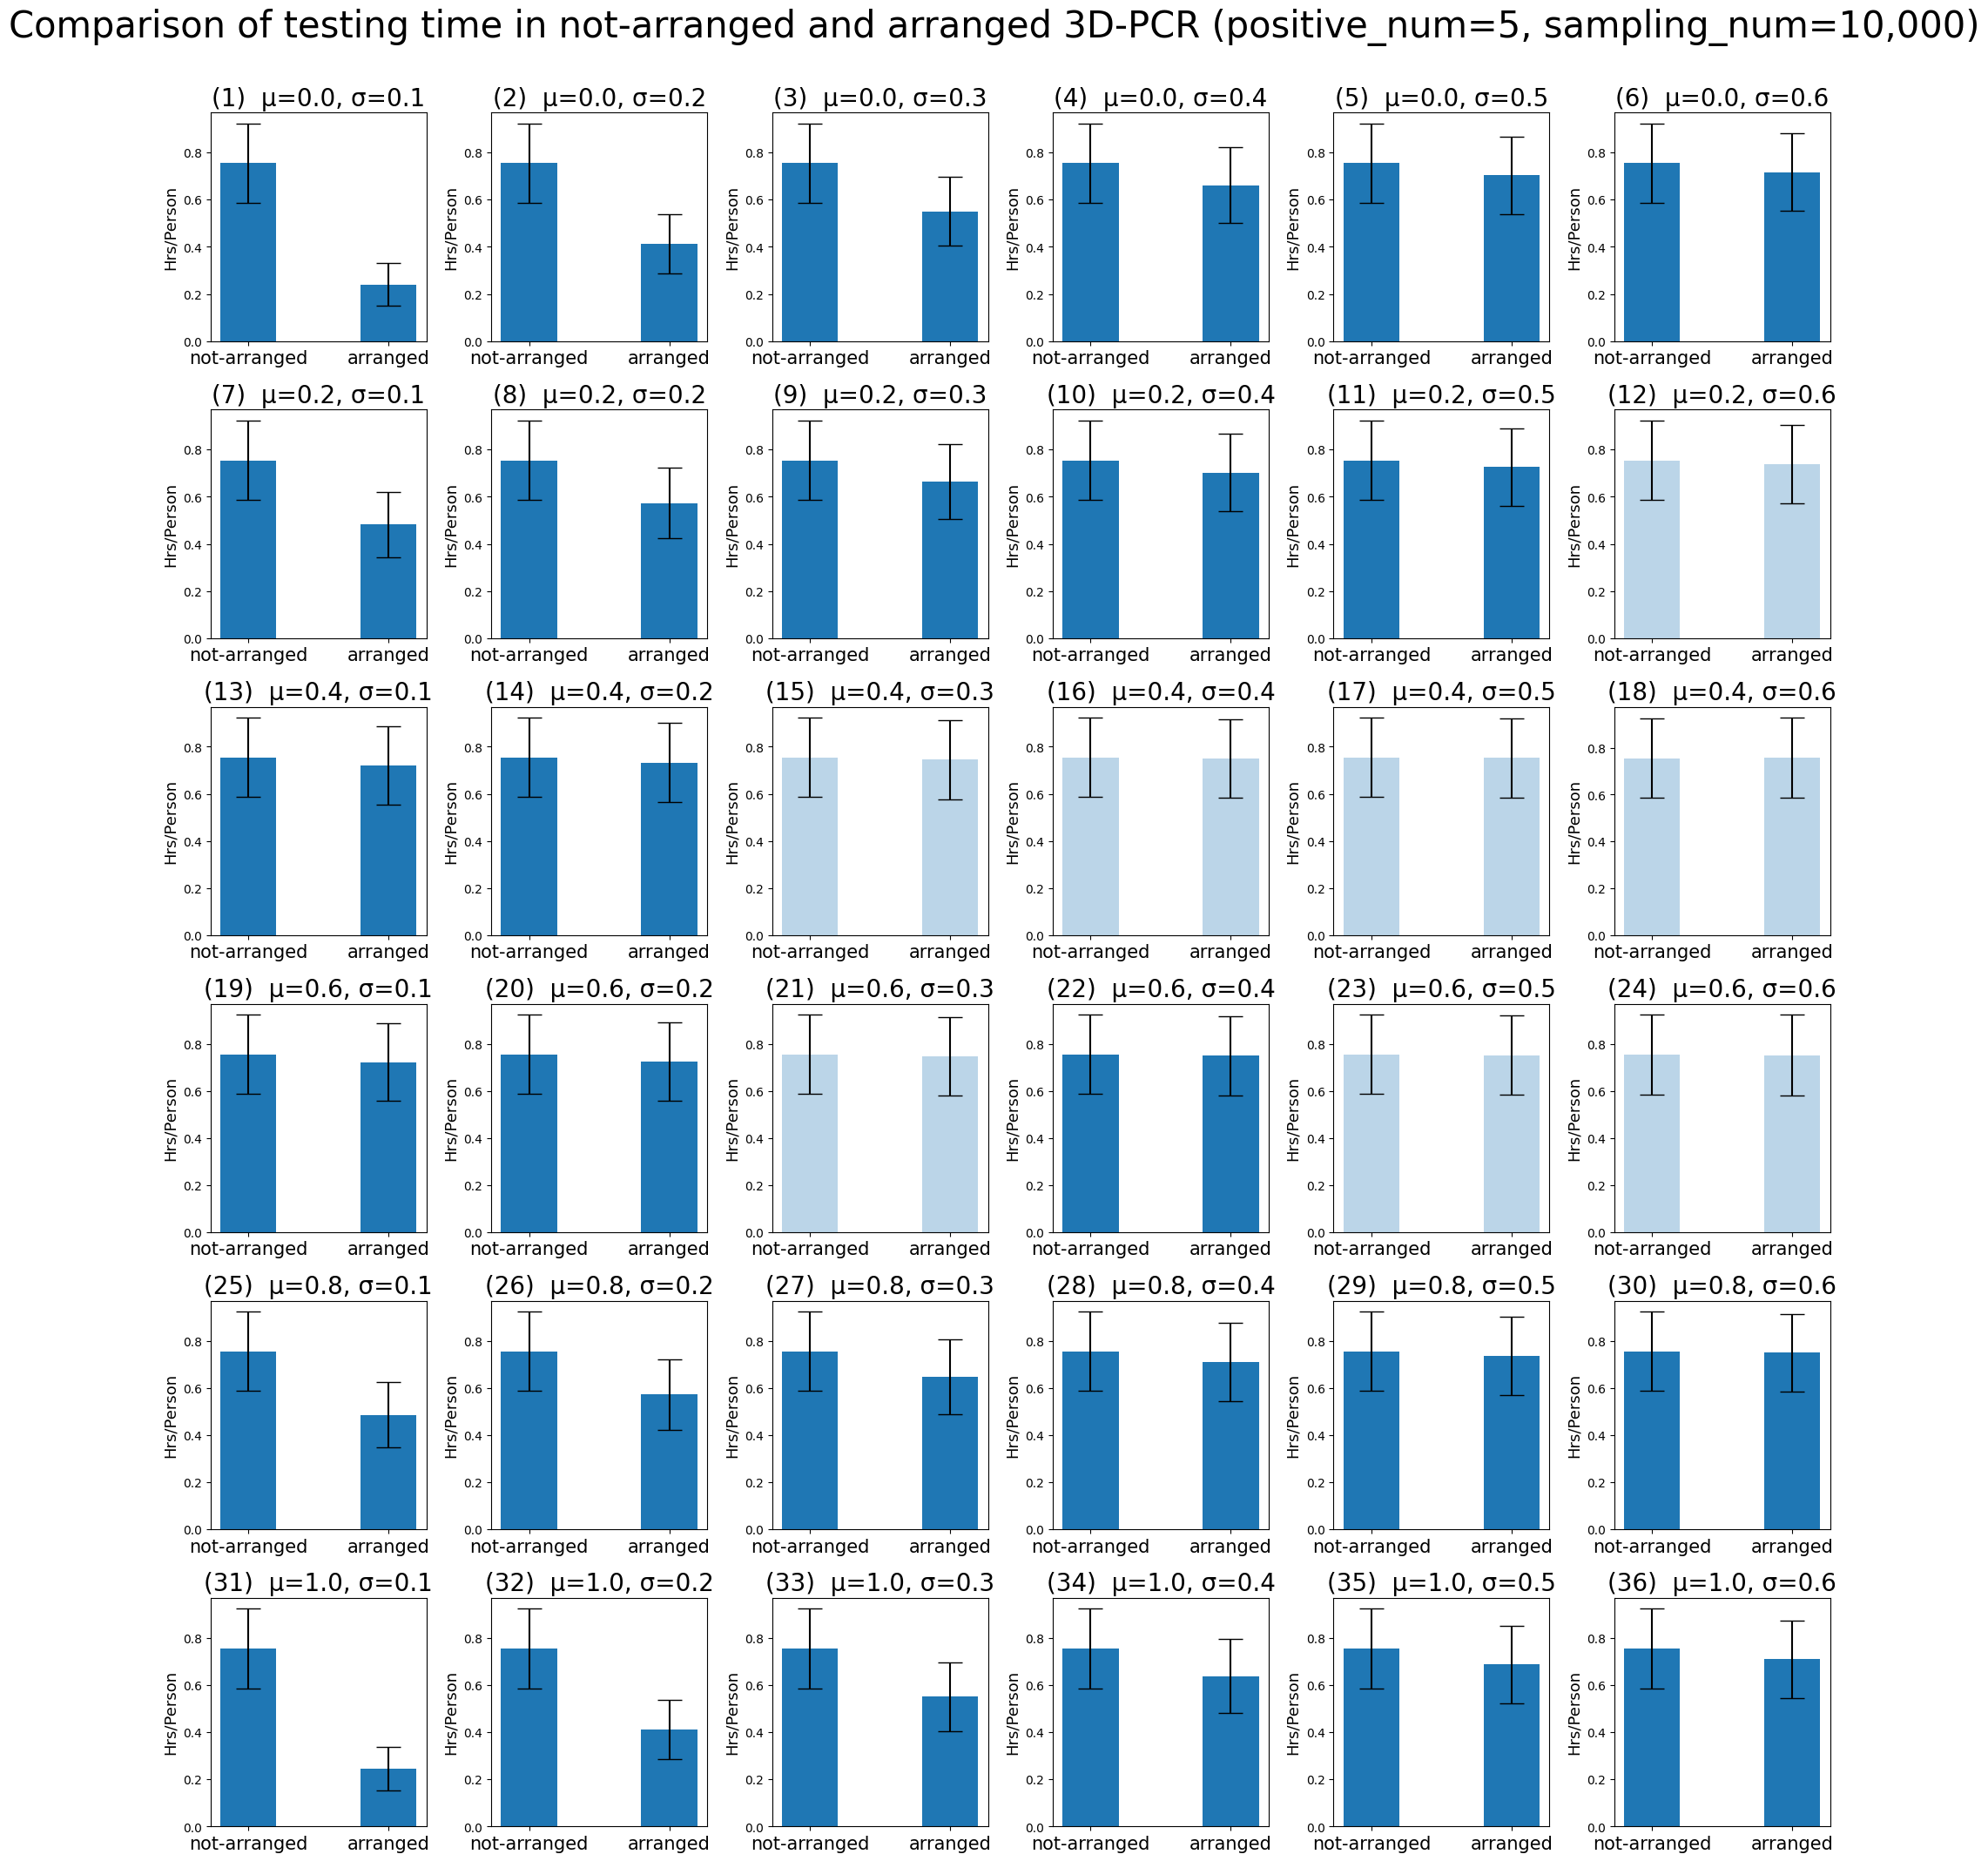

In [31]:
data_density = 1

time_pure = (1.5 + np.minimum(np.array(result_3_pure_list)*0.25, 2) * ((np.array(result_3_pure_list) - 1) // 96 + 1)) / 960
time_arranged = (1.5 + np.minimum(np.array(result_3_arranged_list)*0.25, 2) * ((np.array(result_3_arranged_list) - 1) // 96 + 1)) / 960
time_pure = time_pure[data_density, :, :].tolist()
time_arranged = time_arranged[data_density, :, :].tolist()

# print(len(cost_pure))
fig = plt.figure(figsize=(24, 24))
mean_improvement = []

for i in range(len(hidden_probability_list)):
    # print(len(time_arranged[i]))
    ax = fig.add_subplot(6, 6, i+1)

    cost_mean_pure, cost_mean_arranged = np.mean(cost_pure[i]), np.mean(cost_arranged[i])
    cost_std_pure, cost_std_arranged = np.std(cost_pure[i]), np.std(cost_arranged[i])

    mean_improvement.append((cost_mean_pure, cost_mean_arranged))
    # print('error') if ~np.all(cost_mean_pure) else None

    # if check_significant_difference(result_3_pure[i], result_3_arranged[i]):
    if check_significant_difference(time_pure[i], time_arranged[i]):
        alpha = 1.0
    else:
        alpha = 0.3

    ax.bar(0, cost_mean_pure, yerr=cost_std_pure, capsize=10, color='#1f77b4', alpha=alpha)
    ax.bar(2, cost_mean_arranged, yerr=cost_std_arranged, capsize=10, color='#1f77b4', alpha=alpha)


    ticks_location = [0, 2]  # この位置に目盛りを設定
    labels = ['not-arranged', 'arranged']   # このラベルを表示

    ax.set_ylabel('Hrs/Person', size=13)
    ax.set_title(f'({i+1})  μ={params[i][0]}, σ={params[i][1]}', size=20)
    ax.set_xticks(ticks_location)
    ax.set_xticklabels(labels, size=15)
    # ax.set_title(f'Simulation results of {shot_num} times')

    ax.ticklabel_format(style='plain',axis='y')

fig.suptitle(f'Comparison of testing time in not-arranged and arranged 3D-PCR (positive_num={cases[data_density]}, sampling_num={shot_num:,})', size=30)
fig.subplots_adjust(wspace=0.3, hspace=0.3, top=0.93)
fig.show()

In [32]:
mean_improvement_time_dict = defaultdict()

for data_density in range(3):
    time_pure = (1.5 + np.minimum(np.array(result_3_pure_list)*0.25, 2) * ((np.array(result_3_pure_list) - 1) // 96 + 1)) / 960
    time_arranged = (1.5 + np.minimum(np.array(result_3_arranged_list)*0.25, 2) * ((np.array(result_3_arranged_list) - 1) // 96 + 1)) / 960
    time_pure = time_pure[data_density, :, :].tolist()
    time_arranged = time_arranged[data_density, :, :].tolist()
    # result_3_pure = result_3_pure_list[data_density]
    # result_3_arranged = result_3_arranged_list[data_density]
    mean_improvement_time = []

    for i in range(len(hidden_probability_list)):
        mean_pure, mean_arranged = np.mean(time_pure[i]), np.mean(time_arranged[i])
        mean_improvement_time.append((mean_pure, mean_arranged))
    mean_improvement_time_dict[cases[data_density]] = mean_improvement_time

improvement_rates_time_list = []
for key in mean_improvement_time_dict.keys():
    # print(mean_improvement_dict[key])
    mean_improved = mean_improvement_time_dict[key]
    improvement_rates_time_list.append((key, np.array([(mean_improved[i][0] - mean_improved[i][1]) / mean_improved[i][0] * 100 for i in range(len(mean_improved))]).reshape((6, 6))))
improvement_rates_time_list.sort(key=lambda x: x[0])
improvement_rates_time_list = [improvement_rates_time_list[i][1] for i in range(len(improvement_rates_time_list))]

improvement_rates_time = np.dstack((improvement_rates_time_list[0], improvement_rates_time_list[1], improvement_rates_time_list[2]))

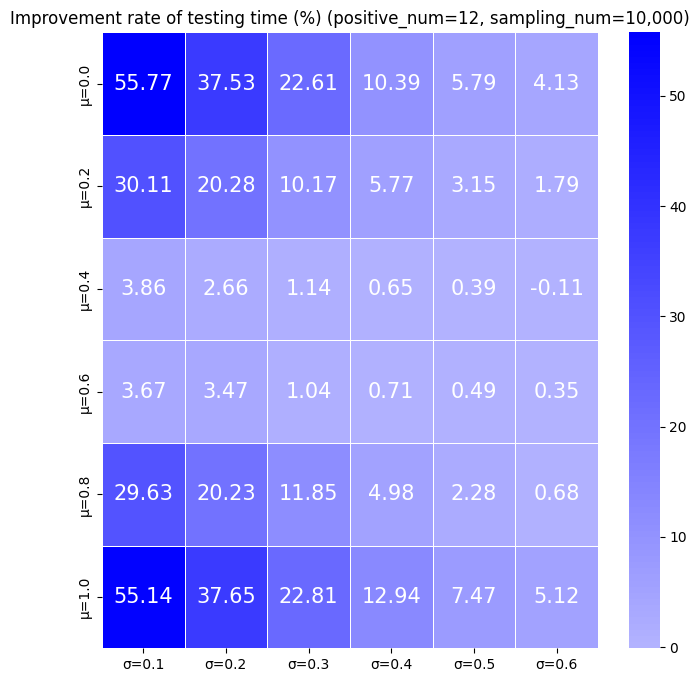

In [34]:
data_density = 2

global_min = improvement_rates_time.min()
global_max = improvement_rates_time.max()

colors = [(0, 0, 1, 0.3), (0, 0, 1, 1)]  # (R, G, B, alpha)
cmap_name = 'custom_div_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(8, 8))
sns.heatmap(improvement_rates_time[:, :, data_density], annot=improvement_rates_time[:, :, data_density], fmt=".2f", cmap=cm, vmin=global_min, vmax=global_max,
            linewidths=0.5, linecolor='white', cbar=True, annot_kws={"color": 'white', 'size': 15})

positions = np.array([0, 1, 2, 3, 4, 5])  + 0.5
plt.xticks(positions, [f'σ={std_devs[i]}' for i in range(len(std_devs))])
plt.yticks(positions, [f'μ={means[i]}' for i in range(len(means))])

plt.title(f'Improvement rate of testing time (%) (positive_num={cases[data_density]}, sampling_num={shot_num:,})')
plt.show()